# Кейс №3 
Прогнозирование размеров сварного шва при электронно-лучевой сварке тонкостенных конструкций аэрокосмического назначения

В качестве исходных данных были взяты результаты экспериментальных исследований, проводимых в целях улучшения технологического процесса электронно-лучевой сварки изделия, сборка которого состоит из элементов, состоящих из разнородного материала. Установка электронно-лучевой сварки, на которой проводились исследования, предназначена для сварки электронным лучом в глубоком вакууме деталей сборочных единиц из нержавеющих сталей, титановых, алюминиевых и специальных сплавов. Существующая установка электронно-лучевой сварки обеспечивает повторяемость режимов в рамках возможностей реализованной системы управления. Работы по сварке выполнялись на образцах-имитаторах, соответствующих технологическому изделию. Для уменьшения вложения энергии при сварке:
1.	Снижалась величина сварочного тока (IW);
2.	Увеличивался ток фокусировки электронного пучка (IF);
3.	Увеличивалась скорость сварки (VW);
4.	Менялось расстояние от поверхности образцов до электронно-оптической системы (FP). 

По совокупности параметров технологических режимов обеспечивались минимально возможные размеры сварных швов: глубина шва (Depth) и ширина шва (Width).
В процессе выполнения работ была произведена электронно-лучевая сварка 18-ти единиц образцов. Результаты металлографического контроля по размерам сварного шва для каждого образца проводились в 4-х поперечных сечениях сварного шва. Ускоряющее напряжение было постоянным в диапазоне 19,8 – 20 кВ. Набор полученных данных собраны в составе режимов сварки, размеров сварочных швов в поперечных сечениях всех образцов.

Датасет: `/data/ebw_data.csv`

**Требуется:** 

Провести прогнозирование глубины (Depth) и ширины (Width) сварного шва в зависимости от параметров технологического процесса (IW, IF, VW, FP).

Таким образом, задание будет решаться в три этапа:

1. Обзор данных;
2. Предобработка данных;
3. Написание и тестирование моделей, выявление лучшей модели.

# 1. Обзор данных

In [34]:
# Импортируем необходимы библиотеки

# библиотеки для работы с данными
import pandas as pd
import numpy as np

# библиотеки для визуализации
from matplotlib import pyplot as plt
import seaborn as sns

In [35]:
# Считываем данные
df = pd.read_csv('../data/ebw_data.csv')
# смотрим перые 5 строчек
df.head()

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48


In [36]:
df.describe()

,IW,IF,VW,FP,Depth,Width
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,45.666667,141.333333,8.638889,78.333333,1.195556,1.970417
std,1.678363,5.145763,2.061078,21.493530,0.225081,0.279040
min,43.000000,131.000000,4.500000,50.000000,0.800000,1.680000
25%,44.000000,139.000000,8.000000,60.000000,1.080000,1.760000
50%,45.500000,141.000000,9.000000,80.000000,1.200000,1.840000
75%,47.000000,146.000000,10.000000,80.000000,1.290000,2.050000
max,49.000000,150.000000,12.000000,125.000000,1.760000,2.600000


In [37]:
# Получаем общую информацию о таблице исходных данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     int64  
 1   IF      72 non-null     int64  
 2   VW      72 non-null     float64
 3   FP      72 non-null     int64  
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.5 KB


Столбцы `IW, IF, VW, FP` являются нашими признаками (фичами), а столбцы `Depth, Width ` являются нашими целевыми переменными (таргетами).

В исходных данных 72 объекта. Пропусков в данных нет. Давайте посмотрим на тепловую карту модулей попарных корреляций фичей и таргетов.

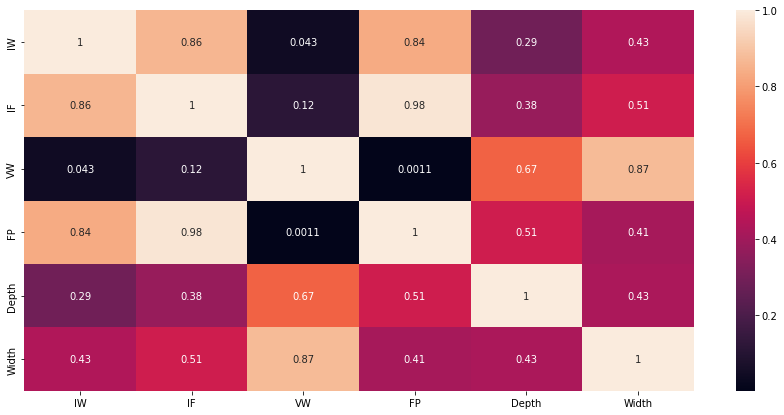

In [38]:
plt.figure(figsize=(15, 7))
sns.heatmap(data=abs(df.corr()), annot=True)
plt.show()

Нетрудно заметить, что все фичи коррелируют с таргетами. Признак `VW` сильнее всех коррелирует с таргетами, при этом корреляция с другими признаками очень близка к 0. Остальные фичи коррелируют друг с другом. Самая сильная связь наблюдается у признаков `FP и IF`, 0.98. Из этого можно сделать вывод, что при обучении линейных моделей мы должны использовать регулиризацию, чтобы избежать переобучения из-за мультиколлениарности признаков.

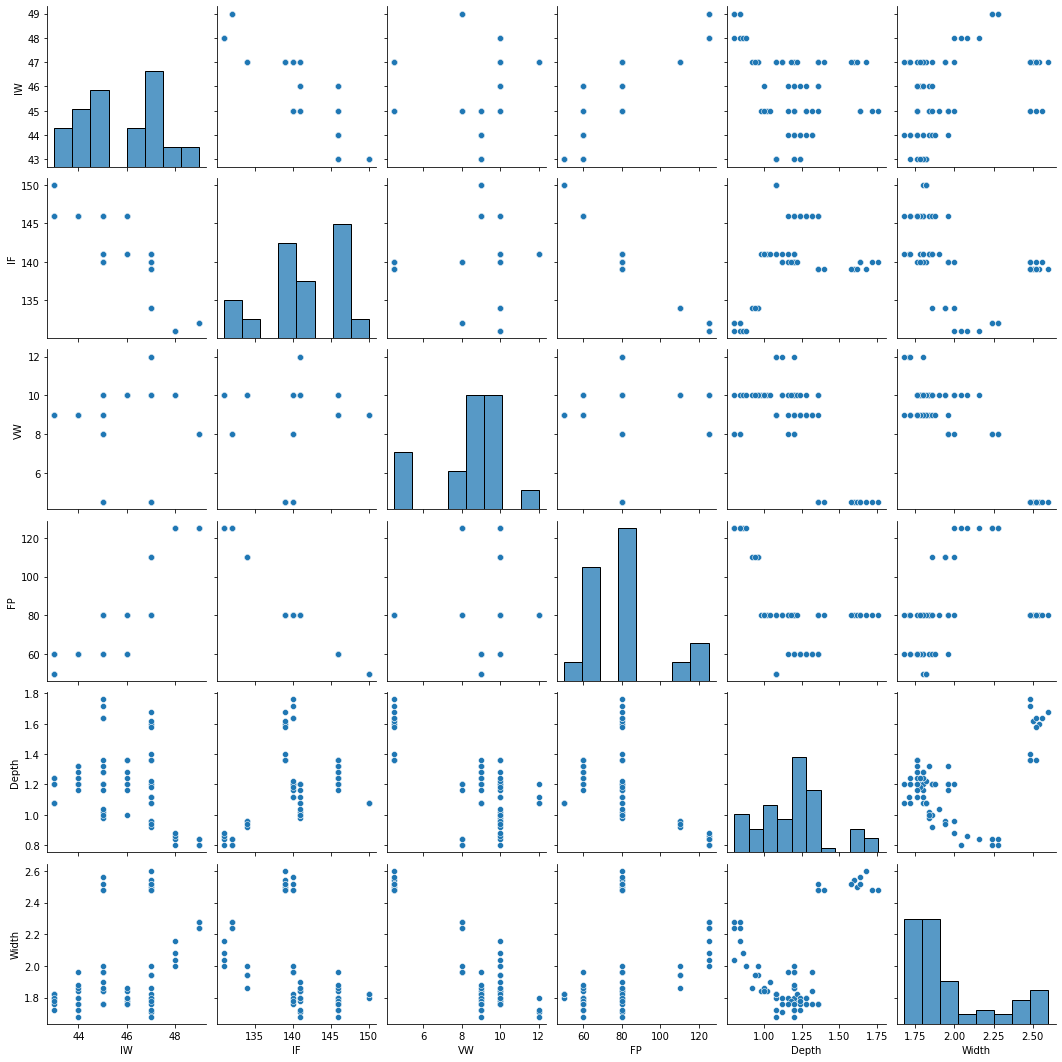

In [39]:
sns.pairplot(df)
plt.show()

Мы можем заметить, что большинство признаков находится друг над другом, стоит проверить данные на дубликаты.

In [40]:
print(df.iloc[:, :-2].duplicated().sum())

57


В датасете 57 дубликатов, в то время как общий размер датасета составляет 72 объекта. Можно сделать усреднение на таргетах при дубликатах. **Но** при использовании линейных моделей, случится тоже самое во время обучения. А при использовании нелинейных моделей(случайный лес) мы можем потерять информацию о нелинейных зависимостях, поэтому усреднение на дубликатах проводить не будем.

# 2. Предобработка данных

In [41]:
# стандартизиурем наш датасет
from sklearn.preprocessing import StandardScaler # импортируем метод для стандартизации датасета

In [42]:
scaler = StandardScaler()
scaler_data_with_features = scaler.fit_transform(df.iloc[:, :-2])
print(scaler_data_with_features[0]) # проверим, что всё получилось

[ 0.8        -0.45662965 -2.02221044  0.07808688]


In [43]:
# Подготовим данные для обучения, разделив Depth и Width
data_with_depth, data_with_width = np.array(df.iloc[:, -2]), np.array(df.iloc[:, -1])
data_with_features = np.array(df.iloc[:, :-2])
# для нейросети оставим их вместе
data_with_depth_width = np.array(df.iloc[:, -2:])

# 3. Написание, тестирование моделей и выявление лучшей модели

# Модель №1 - Гребневая линейная регрессия

Моей первой моделью является регуляризация линейной регрессии, а именно Ridge. Мы используем регуляризацию в целях избежания переобучения от мультиколлениарности признаков (т. к. в `разведочном анализе` была выявлена сильная корреляция между нецелевыми признаками). Не используем Lasso, так как она обладает свойством отбора признаков. Мы в этом не нуждаемся.

Вспомним, что размер нашего датасета равен 72-ум объектам. Мы можем использовать кросс-валидацию для обучения модели, настройки гиперпараметра и оценки обопщённости модели. Поэтому мы приходим к выводу об использовании поэлементной кросс-валидации. **Но** важно отметить, что мы должны обучать модель на предобработанных данных, а проверять на исходных. После 72 итераций мы должны усреднить ошибку, для получения итоговой метрики. Мы будем усреднять mse.

Мы напишем 2 модели, одна будет предсказывать `Depth` по признаками, другая - `Width`. Поэтому разобьём преобработанные и исходные данные.

In [44]:
from sklearn.model_selection import LeaveOneOut # импортируем поэлемнтарную кросс-валидацию
from sklearn.linear_model import Ridge # импортируем регуляризацию Ridge
from sklearn.metrics import mean_squared_error as mse # импортируем метрику mse

In [45]:
# Функция, которая является поэлементарной кроссвалидации.
# Обучение происходит на тренировочных данных, а проверка на тестовых данных
def my_cross_val_score(x_data, y_data, splitter, model):
    
    list_with_mse = [] # список с mse ошибки модели на каждой итерации
    
    # список перебора индексов для разбиения на тренировочную и тестовую выборки
    for train_index, test_index in splitter.split(x_data):
       
        # разбиение на выборки
        x_train, x_test = x_data[train_index], x_data[test_index] 
        y_train, y_test = y_data[train_index], y_data[test_index]
        
        scaler = StandardScaler() # объявляем метод для станжартизации
        new_x_train = scaler.fit_transform(x_train) # стандартизируем обучающие данные
        new_x_test = scaler.transform(x_test) # преобразовываем тестовые данные
        
        # обучаем переданную модель
        model.fit(new_x_train, y_train)
        # делаем предсказание
        model_predict = model.predict(new_x_test)
        # считаем mse ошибки
        my_mse_error = mse(y_test, model_predict)
        # добавляем в список
        list_with_mse.append(my_mse_error)
        
    return np.mean(list_with_mse) # возвращаем усредненную mse

In [46]:
# функция для отрисовки графика кривой усреднённой mse ошибки.
# list_with_errors - список усреднённых ошибок
# alpha - гиперпараметр
# min_error - минимальная усреднённая mse ошибки
def plot_graphic(list_with_errors, alpha, min_error):
    plt.figure(figsize=(15, 7))
    # по х отрисосываем alpha в диапазоне от 0 до 10, по у отрисовываем усреднённую mse
    plt.plot([i / 10 for i in range(101)], list_with_errors)
    # выбеляем точкой минимальную mse
    plt.scatter(alpha, min_error, c='red')
    # подписываем оси
    plt.xlabel('alpha')
    plt.ylabel('mse')
    plt.show()

In [47]:
# Функция, написанная для избежания повторений кода при работе с Ridge
# x_data, y_data - параметры для обучения и тестирования
# splitter - параметр для передачи LeaveOneOut()
def find_best_model_Ridge(x_data, y_data, splitter):
    # список со всеми усреднёнными mse 
    list_with_errors = []
    
    # просмотр mse моделей с alpha от 0 до 10 
    for i in range(101):
        accuracy_depth = my_cross_val_score(x_data,
                                 y_data,
                                 splitter,
                                 Ridge(alpha=i / 10))
        # добавляем усреднённую mse в список
        list_with_errors.append(accuracy_depth)

    # минимальная ошибка
    min_error = min(list_with_errors)
    # гиперпараметр alpha, который дал наименьшую ошибку
    alpha = list_with_errors.index(min_error) / 10
    # вывод лучшего гиперпараметра и минимальной ошибки
    print('alpha:', alpha, 'min error:', min_error)
    # отрисовываем кривую усреднённых для наглядности
    plot_graphic(list_with_errors, alpha, min_error)
    # возвращаем лучший гиперпараметр и минимальную ошибку
    return alpha, min_error

# Модель для пердсказания `Depth`

Оценка для моделей, которые предсказывают Depth:
alpha: 0.0 min error: 0.011271229224803836


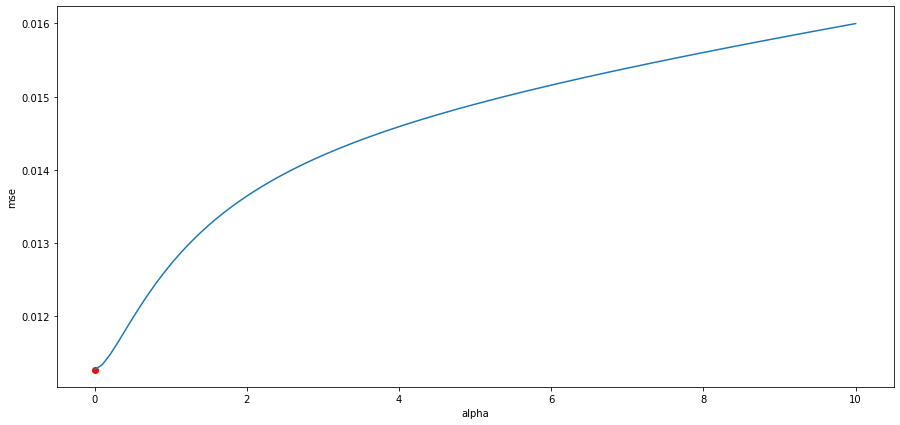

In [48]:
print('Оценка для моделей, которые предсказывают Depth:')
accuracy_model_depth = find_best_model_Ridge(data_with_features, data_with_depth, LeaveOneOut())

# Модель для пердсказания `Width`

Оценка для моделей, которые предсказывают Width:
alpha: 0.9 min error: 0.004939679967163883


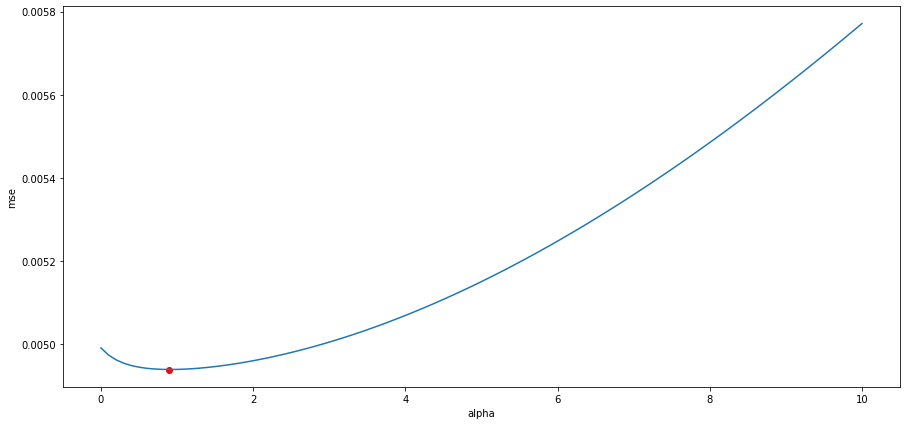

In [49]:
print('Оценка для моделей, которые предсказывают Width:')
accuracy_model_width = find_best_model_Ridge(data_with_features, data_with_width, LeaveOneOut())

In [50]:
# Посмотрим общую ошибку моделей Ridge при решении данной задачи
accuracy_ridge = (accuracy_model_width[1] + accuracy_model_width[1]) / 2
print(accuracy_ridge)

0.004939679967163883


# Модель №2 - Случайный лес

В данном разделе мы будем использовать модель Случайного леса(RandomForestRegressor). Подбор оптимальных гиперпараметров мы будем делать с помощью RandomizedSearchCV. Мы не используем GridSearchCV, в целях экономии ресурсов. Мы можем быть уверены, что лучшие найденные параметры действительно являются лучшим сочетанием оптимальных параметров, поскольку поиск полностью рандомизирован.

Мы напишем 2 модели, одна будет предсказывать `Depth` по признаками, другая - `Width`.

In [51]:
from sklearn.ensemble import RandomForestRegressor # импортируем случайный лес
# импортируем метод для подбора параметров и кросс-валидацию для нейронной сети
from sklearn.model_selection import RandomizedSearchCV, KFold 

# Модель для пердсказания `Depth`

In [52]:
# создаём словарь с параметрами и значениями, по которым нужно выбрать лучший экземпляр
distributions = {
    "n_estimators": [i for i in range(10, 101, 10)],
    "criterion": ['squared_error'],
    "max_features": [i for i in range(1, 5)],
    "min_samples_leaf": [i for i in range(1, 5)],
    "max_depth": [i for i in range(4, 16)],
    "min_samples_split": [i for i in range(2, 5)]
}
# ищем лучший образец
clf_depth = RandomizedSearchCV(RandomForestRegressor(),
                   param_distributions=distributions, 
                   cv=LeaveOneOut(), 
                   scoring='neg_mean_squared_error',
                   n_iter=200)
clf_depth.fit(scaler_data_with_features, data_with_depth)
# сохраняем лучший экземпляр
forest_depth = clf_depth.best_estimator_
# сохраним и выведем среднюю ошибку
accuracy_forest_depth = -clf_depth.best_score_
print('mse', accuracy_forest_depth)

mse 0.004604072450458013


# Модель для пердсказания `Width`

In [53]:
# создаём словарь с параметрами и значениями, по которым нужно выбрать лучший экземпляр
distributions = {
    "n_estimators": [i for i in range(10, 101, 10)],
    "criterion": ['squared_error'],
    "max_features": [i for i in range(1, 5)],
    "min_samples_leaf": [i for i in range(1, 5)],
    "max_depth": [i for i in range(4, 16)],
    "min_samples_split": [i for i in range(2, 5)]
}
# ищем лучший образец
clf_width = RandomizedSearchCV(RandomForestRegressor(),
                   param_distributions=distributions, 
                   cv=LeaveOneOut(), 
                   scoring='neg_mean_squared_error',
                   n_iter=200)
clf_width.fit(scaler_data_with_features, data_with_width)
# сохраняем лучший экземпляр
forest_width = clf_width.best_estimator_
# сохраним и выведем среднюю ошибку
accuracy_forest_width = -clf_width.best_score_
print('mse', accuracy_forest_width)

mse 0.0025791847090100785


In [54]:
# Посмотрим общую ошибку моделей RandomForestRegressor при решении данной задачи
accuracy_forest = (accuracy_forest_depth + accuracy_forest_width) / 2
print(accuracy_forest)

0.003591628579734046


# Модель №3 - Нейронная сеть

Из-за небольшого количества образцов мы будем использовать очень маленькую сеть с двумя слоями. Это обусловлено тем, что чем меньше обучающих данных, тем скорее наступит переобучение, а использование маленькой сети — один из способов борьбы с ним. Так как линейная модель хорошо себя показала, мы будем использовать функции активации `relu`. Для предотвращения переобучения мы будем рассматривать количество эпох как гиперпараметр. Выберём количество эпох для обученися с наименьшей mse на тестовых данных.

In [55]:
from keras import models # Метод для создания модели
from keras import layers # Метод для создания слоёв нейросети

In [56]:
# Функция для построения модели нейронной сети
def build_model():
    # создаём модель
    model = models.Sequential() 
    # добавляем входной слой с функцией активации 'relu'
    model.add(layers.Dense(16, activation='relu', input_shape=(4,)))
    # добавляем второй слой с функцией активации 'relu'
    model.add(layers.Dense(8, activation='relu'))
    # добавляем выходной слой на 2 выхода
    model.add(layers.Dense(2))
    # компилируем модель. В качестве оптимизатора берём алгоритм стохастического градиентного спуска
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])
    return model

In [57]:
# Функция, которая является кроссвалидацией.
# Обучение происходит на тренировочных данных, а проверка на тестовых данных
def my_cross_val_score_for_networks(x_data, y_data, splitter, epoch):
    
    list_with_mse = [] # список с mse ошибки модели на каждой итерации
    
    # список перебора индексов для разбиения на тренировочную и тестовую выборки
    for train_index, test_index in splitter.split(x_data):
       
        # разбиение на выборки
        x_train, x_test = x_data[train_index], x_data[test_index] 
        y_train, y_test = y_data[train_index], y_data[test_index]
        
        # объявление модели
        model = build_model()
        
        # обучаем переданную модель
        model.fit(x=x_train, 
                  y=y_train, 
                  epochs=epoch, 
                  batch_size=18)
        # делаем предсказание
        model_predict = model.predict(x_test)
        # считаем mse ошибки
        my_mse_error = mse(y_test, model_predict)
        # добавляем в список
        list_with_mse.append(my_mse_error)
        
    return np.mean(list_with_mse) # возвращаем усредненную mse

In [58]:
list_with_error = [] # список с mse на кросс-валидации каждой модели с разным количеством эпох
list_with_epochs = [i for i in range(50, 251, 10)] # список эпох

for epoch in list_with_epochs:
    list_with_error.append(my_cross_val_score_for_networks(scaler_data_with_features, 
                                              data_with_depth_width, 
                                              KFold(n_splits=4), 
                                              epoch))
accuracy_network = min(list_with_error) # самая лучшая mse
print('Min mse:', accuracy_network)
print('Epochs:', list_with_epochs[list_with_error.index(accuracy_network)]) # оптимальное количество эпох

Epoch 1/50
3/3 [==============================] - 1s 5ms/step - loss: 1.8197 - mse: 1.8197
Epoch 2/50
3/3 [==============================] - 0s 4ms/step - loss: 1.6355 - mse: 1.6355
Epoch 3/50
3/3 [==============================] - 0s 4ms/step - loss: 1.5089 - mse: 1.5089
Epoch 4/50
3/3 [==============================] - 0s 4ms/step - loss: 1.3973 - mse: 1.3973
Epoch 5/50
3/3 [==============================] - 0s 4ms/step - loss: 1.2955 - mse: 1.2955
Epoch 6/50
3/3 [==============================] - 0s 4ms/step - loss: 1.2050 - mse: 1.2050
Epoch 7/50
3/3 [==============================] - 0s 4ms/step - loss: 1.1209 - mse: 1.1209
Epoch 8/50
3/3 [==============================] - 0s 4ms/step - loss: 1.0445 - mse: 1.0445
Epoch 9/50
3/3 [==============================] - 0s 6ms/step - loss: 0.9734 - mse: 0.9734
Epoch 10/50
3/3 [==============================] - 0s 4ms/step - loss: 0.9071 - mse: 0.9071
Epoch 11/50
3/3 [==============================] - 0s 4ms/step - loss: 0.8454 - mse: 0.84

3/3 [==============================] - 0s 4ms/step - loss: 0.8735 - mse: 0.8735
Epoch 41/50
3/3 [==============================] - 0s 4ms/step - loss: 0.8319 - mse: 0.8319
Epoch 42/50
3/3 [==============================] - 0s 4ms/step - loss: 0.7914 - mse: 0.7914
Epoch 43/50
3/3 [==============================] - 0s 4ms/step - loss: 0.7513 - mse: 0.7513
Epoch 44/50
3/3 [==============================] - 0s 4ms/step - loss: 0.7131 - mse: 0.7131
Epoch 45/50
3/3 [==============================] - 0s 4ms/step - loss: 0.6760 - mse: 0.6760
Epoch 46/50
3/3 [==============================] - 0s 4ms/step - loss: 0.6399 - mse: 0.6399
Epoch 47/50
3/3 [==============================] - 0s 4ms/step - loss: 0.6055 - mse: 0.6055
Epoch 48/50
3/3 [==============================] - 0s 4ms/step - loss: 0.5717 - mse: 0.5717
Epoch 49/50
3/3 [==============================] - 0s 4ms/step - loss: 0.5397 - mse: 0.5397
Epoch 50/50
3/3 [==============================] - 0s 4ms/step - loss: 0.5090 - mse: 0.5090


3/3 [==============================] - 0s 4ms/step - loss: 0.4542 - mse: 0.4542
Epoch 30/50
3/3 [==============================] - 0s 4ms/step - loss: 0.4287 - mse: 0.4287
Epoch 31/50
3/3 [==============================] - 0s 4ms/step - loss: 0.3976 - mse: 0.3976
Epoch 32/50
3/3 [==============================] - 0s 4ms/step - loss: 0.3729 - mse: 0.3729
Epoch 33/50
3/3 [==============================] - 0s 4ms/step - loss: 0.3486 - mse: 0.3486
Epoch 34/50
3/3 [==============================] - 0s 4ms/step - loss: 0.3248 - mse: 0.3248
Epoch 35/50
3/3 [==============================] - 0s 0s/step - loss: 0.3033 - mse: 0.3033
Epoch 36/50
3/3 [==============================] - 0s 4ms/step - loss: 0.2866 - mse: 0.2866
Epoch 37/50
3/3 [==============================] - 0s 0s/step - loss: 0.2668 - mse: 0.2668
Epoch 38/50
3/3 [==============================] - 0s 4ms/step - loss: 0.2494 - mse: 0.2494
Epoch 39/50
3/3 [==============================] - 0s 4ms/step - loss: 0.2343 - mse: 0.2343
Ep

Epoch 1/60
3/3 [==============================] - 1s 4ms/step - loss: 3.9853 - mse: 3.9853
Epoch 2/60
3/3 [==============================] - 0s 0s/step - loss: 3.7101 - mse: 3.7101
Epoch 3/60
3/3 [==============================] - 0s 0s/step - loss: 3.5535 - mse: 3.5535
Epoch 4/60
3/3 [==============================] - 0s 4ms/step - loss: 3.4349 - mse: 3.4349
Epoch 5/60
3/3 [==============================] - 0s 4ms/step - loss: 3.3468 - mse: 3.3468
Epoch 6/60
3/3 [==============================] - 0s 0s/step - loss: 3.2739 - mse: 3.2739
Epoch 7/60
3/3 [==============================] - 0s 4ms/step - loss: 3.2040 - mse: 3.2040
Epoch 8/60
3/3 [==============================] - 0s 4ms/step - loss: 3.1423 - mse: 3.1423
Epoch 9/60
3/3 [==============================] - 0s 4ms/step - loss: 3.0837 - mse: 3.0837
Epoch 10/60
3/3 [==============================] - 0s 4ms/step - loss: 3.0279 - mse: 3.0279
Epoch 11/60
3/3 [==============================] - 0s 0s/step - loss: 2.9731 - mse: 2.9731
E

3/3 [==============================] - 0s 4ms/step - loss: 0.7949 - mse: 0.7949
Epoch 23/60
3/3 [==============================] - 0s 0s/step - loss: 0.7590 - mse: 0.7590
Epoch 24/60
3/3 [==============================] - 0s 4ms/step - loss: 0.7254 - mse: 0.7254
Epoch 25/60
3/3 [==============================] - 0s 4ms/step - loss: 0.6904 - mse: 0.6904
Epoch 26/60
3/3 [==============================] - 0s 4ms/step - loss: 0.6551 - mse: 0.6551
Epoch 27/60
3/3 [==============================] - 0s 4ms/step - loss: 0.6213 - mse: 0.6213
Epoch 28/60
3/3 [==============================] - 0s 0s/step - loss: 0.5854 - mse: 0.5854
Epoch 29/60
3/3 [==============================] - 0s 4ms/step - loss: 0.5523 - mse: 0.5523
Epoch 30/60
3/3 [==============================] - 0s 4ms/step - loss: 0.5222 - mse: 0.5222
Epoch 31/60
3/3 [==============================] - 0s 4ms/step - loss: 0.4936 - mse: 0.4936
Epoch 32/60
3/3 [==============================] - 0s 4ms/step - loss: 0.4649 - mse: 0.4649
Ep

3/3 [==============================] - 0s 4ms/step - loss: 0.0581 - mse: 0.0581
Epoch 52/60
3/3 [==============================] - 0s 0s/step - loss: 0.0557 - mse: 0.0557
Epoch 53/60
3/3 [==============================] - 0s 4ms/step - loss: 0.0528 - mse: 0.0528
Epoch 54/60
3/3 [==============================] - 0s 4ms/step - loss: 0.0510 - mse: 0.0510
Epoch 55/60
3/3 [==============================] - 0s 0s/step - loss: 0.0487 - mse: 0.0487
Epoch 56/60
3/3 [==============================] - 0s 4ms/step - loss: 0.0459 - mse: 0.0459
Epoch 57/60
3/3 [==============================] - 0s 4ms/step - loss: 0.0450 - mse: 0.0450
Epoch 58/60
3/3 [==============================] - 0s 4ms/step - loss: 0.0433 - mse: 0.0433
Epoch 59/60
3/3 [==============================] - 0s 4ms/step - loss: 0.0407 - mse: 0.0407
Epoch 60/60
3/3 [==============================] - 0s 4ms/step - loss: 0.0393 - mse: 0.0393
Epoch 1/70
3/3 [==============================] - 1s 9ms/step - loss: 1.4799 - mse: 1.4799
Epo

3/3 [==============================] - 0s 4ms/step - loss: 1.7344 - mse: 1.7344
Epoch 11/70
3/3 [==============================] - 0s 4ms/step - loss: 1.6552 - mse: 1.6552
Epoch 12/70
3/3 [==============================] - 0s 4ms/step - loss: 1.5751 - mse: 1.5751
Epoch 13/70
3/3 [==============================] - 0s 4ms/step - loss: 1.4999 - mse: 1.4999
Epoch 14/70
3/3 [==============================] - 0s 4ms/step - loss: 1.4277 - mse: 1.4277
Epoch 15/70
3/3 [==============================] - 0s 4ms/step - loss: 1.3477 - mse: 1.3477
Epoch 16/70
3/3 [==============================] - 0s 0s/step - loss: 1.2711 - mse: 1.2711
Epoch 17/70
3/3 [==============================] - 0s 4ms/step - loss: 1.1922 - mse: 1.1922
Epoch 18/70
3/3 [==============================] - 0s 4ms/step - loss: 1.1099 - mse: 1.1099
Epoch 19/70
3/3 [==============================] - 0s 4ms/step - loss: 1.0363 - mse: 1.0363
Epoch 20/70
3/3 [==============================] - 0s 4ms/step - loss: 0.9667 - mse: 0.9667
E

3/3 [==============================] - 0s 4ms/step - loss: 0.3297 - mse: 0.3297
Epoch 30/70
3/3 [==============================] - 0s 4ms/step - loss: 0.3038 - mse: 0.3038
Epoch 31/70
3/3 [==============================] - 0s 4ms/step - loss: 0.2783 - mse: 0.2783
Epoch 32/70
3/3 [==============================] - 0s 4ms/step - loss: 0.2557 - mse: 0.2557
Epoch 33/70
3/3 [==============================] - 0s 0s/step - loss: 0.2353 - mse: 0.2353
Epoch 34/70
3/3 [==============================] - 0s 4ms/step - loss: 0.2180 - mse: 0.2180
Epoch 35/70
3/3 [==============================] - 0s 4ms/step - loss: 0.2022 - mse: 0.2022
Epoch 36/70
3/3 [==============================] - 0s 7ms/step - loss: 0.1903 - mse: 0.1903
Epoch 37/70
3/3 [==============================] - 0s 3ms/step - loss: 0.1756 - mse: 0.1756
Epoch 38/70
3/3 [==============================] - 0s 3ms/step - loss: 0.1648 - mse: 0.1648
Epoch 39/70
3/3 [==============================] - 0s 4ms/step - loss: 0.1543 - mse: 0.1543
E

3/3 [==============================] - 0s 4ms/step - loss: 0.1155 - mse: 0.1155
Epoch 49/70
3/3 [==============================] - 0s 4ms/step - loss: 0.1097 - mse: 0.1097
Epoch 50/70
3/3 [==============================] - 0s 4ms/step - loss: 0.1036 - mse: 0.1036
Epoch 51/70
3/3 [==============================] - 0s 4ms/step - loss: 0.0999 - mse: 0.0999
Epoch 52/70
3/3 [==============================] - 0s 4ms/step - loss: 0.0953 - mse: 0.0953
Epoch 53/70
3/3 [==============================] - 0s 4ms/step - loss: 0.0898 - mse: 0.0898
Epoch 54/70
3/3 [==============================] - 0s 4ms/step - loss: 0.0866 - mse: 0.0866
Epoch 55/70
3/3 [==============================] - 0s 4ms/step - loss: 0.0831 - mse: 0.0831
Epoch 56/70
3/3 [==============================] - 0s 0s/step - loss: 0.0791 - mse: 0.0791
Epoch 57/70
3/3 [==============================] - 0s 4ms/step - loss: 0.0768 - mse: 0.0768
Epoch 58/70
3/3 [==============================] - 0s 4ms/step - loss: 0.0734 - mse: 0.0734
E

3/3 [==============================] - 0s 4ms/step - loss: 0.1835 - mse: 0.1835
Epoch 68/80
3/3 [==============================] - 0s 4ms/step - loss: 0.1730 - mse: 0.1730
Epoch 69/80
3/3 [==============================] - 0s 4ms/step - loss: 0.1632 - mse: 0.1632
Epoch 70/80
3/3 [==============================] - 0s 0s/step - loss: 0.1544 - mse: 0.1544
Epoch 71/80
3/3 [==============================] - 0s 4ms/step - loss: 0.1443 - mse: 0.1443
Epoch 72/80
3/3 [==============================] - 0s 0s/step - loss: 0.1368 - mse: 0.1368
Epoch 73/80
3/3 [==============================] - 0s 4ms/step - loss: 0.1286 - mse: 0.1286
Epoch 74/80
3/3 [==============================] - 0s 4ms/step - loss: 0.1215 - mse: 0.1215
Epoch 75/80
3/3 [==============================] - 0s 4ms/step - loss: 0.1162 - mse: 0.1162
Epoch 76/80
3/3 [==============================] - 0s 4ms/step - loss: 0.1088 - mse: 0.1088
Epoch 77/80
3/3 [==============================] - 0s 4ms/step - loss: 0.1028 - mse: 0.1028
Ep

3/3 [==============================] - 0s 4ms/step - loss: 0.0230 - mse: 0.0230
Epoch 77/80
3/3 [==============================] - 0s 4ms/step - loss: 0.0221 - mse: 0.0221
Epoch 78/80
3/3 [==============================] - 0s 4ms/step - loss: 0.0214 - mse: 0.0214
Epoch 79/80
3/3 [==============================] - 0s 4ms/step - loss: 0.0207 - mse: 0.0207
Epoch 80/80
3/3 [==============================] - 0s 4ms/step - loss: 0.0211 - mse: 0.0211
Epoch 1/80
3/3 [==============================] - 1s 10ms/step - loss: 2.8545 - mse: 2.8545
Epoch 2/80
3/3 [==============================] - 0s 4ms/step - loss: 2.6923 - mse: 2.6923
Epoch 3/80
3/3 [==============================] - 0s 4ms/step - loss: 2.5814 - mse: 2.5814
Epoch 4/80
3/3 [==============================] - 0s 4ms/step - loss: 2.4852 - mse: 2.4852
Epoch 5/80
3/3 [==============================] - 0s 4ms/step - loss: 2.3976 - mse: 2.3976
Epoch 6/80
3/3 [==============================] - 0s 4ms/step - loss: 2.3169 - mse: 2.3169
Epoch

3/3 [==============================] - 0s 4ms/step - loss: 3.5575 - mse: 3.5575
Epoch 6/80
3/3 [==============================] - 0s 4ms/step - loss: 3.4650 - mse: 3.4650
Epoch 7/80
3/3 [==============================] - 0s 4ms/step - loss: 3.3795 - mse: 3.3795
Epoch 8/80
3/3 [==============================] - 0s 4ms/step - loss: 3.3039 - mse: 3.3039
Epoch 9/80
3/3 [==============================] - 0s 0s/step - loss: 3.2330 - mse: 3.2330
Epoch 10/80
3/3 [==============================] - 0s 4ms/step - loss: 3.1688 - mse: 3.1688
Epoch 11/80
3/3 [==============================] - 0s 4ms/step - loss: 3.1074 - mse: 3.1074
Epoch 12/80
3/3 [==============================] - 0s 4ms/step - loss: 3.0510 - mse: 3.0510
Epoch 13/80
3/3 [==============================] - 0s 4ms/step - loss: 2.9940 - mse: 2.9940
Epoch 14/80
3/3 [==============================] - 0s 0s/step - loss: 2.9229 - mse: 2.9229
Epoch 15/80
3/3 [==============================] - 0s 4ms/step - loss: 2.8461 - mse: 2.8461
Epoch 

3/3 [==============================] - 0s 4ms/step - loss: 0.9176 - mse: 0.9176
Epoch 15/90
3/3 [==============================] - 0s 4ms/step - loss: 0.8578 - mse: 0.8578
Epoch 16/90
3/3 [==============================] - 0s 4ms/step - loss: 0.8031 - mse: 0.8031
Epoch 17/90
3/3 [==============================] - 0s 0s/step - loss: 0.7523 - mse: 0.7523
Epoch 18/90
3/3 [==============================] - 0s 4ms/step - loss: 0.7034 - mse: 0.7034
Epoch 19/90
3/3 [==============================] - 0s 4ms/step - loss: 0.6563 - mse: 0.6563
Epoch 20/90
3/3 [==============================] - 0s 4ms/step - loss: 0.6119 - mse: 0.6119
Epoch 21/90
3/3 [==============================] - 0s 4ms/step - loss: 0.5717 - mse: 0.5717
Epoch 22/90
3/3 [==============================] - 0s 4ms/step - loss: 0.5320 - mse: 0.5320
Epoch 23/90
3/3 [==============================] - 0s 4ms/step - loss: 0.4952 - mse: 0.4952
Epoch 24/90
3/3 [==============================] - 0s 0s/step - loss: 0.4609 - mse: 0.4609
Ep

3/3 [==============================] - 0s 4ms/step - loss: 1.1210 - mse: 1.1210
Epoch 14/90
3/3 [==============================] - 0s 4ms/step - loss: 1.0538 - mse: 1.0538
Epoch 15/90
3/3 [==============================] - 0s 0s/step - loss: 0.9905 - mse: 0.9905
Epoch 16/90
3/3 [==============================] - 0s 4ms/step - loss: 0.9314 - mse: 0.9314
Epoch 17/90
3/3 [==============================] - 0s 4ms/step - loss: 0.8741 - mse: 0.8741
Epoch 18/90
3/3 [==============================] - 0s 4ms/step - loss: 0.8167 - mse: 0.8167
Epoch 19/90
3/3 [==============================] - 0s 4ms/step - loss: 0.7612 - mse: 0.7612
Epoch 20/90
3/3 [==============================] - 0s 0s/step - loss: 0.7057 - mse: 0.7057
Epoch 21/90
3/3 [==============================] - 0s 4ms/step - loss: 0.6533 - mse: 0.6533
Epoch 22/90
3/3 [==============================] - 0s 4ms/step - loss: 0.6026 - mse: 0.6026
Epoch 23/90
3/3 [==============================] - 0s 4ms/step - loss: 0.5532 - mse: 0.5532
Ep

3/3 [==============================] - 0s 0s/step - loss: 2.1706 - mse: 2.1706
Epoch 13/90
3/3 [==============================] - 0s 4ms/step - loss: 2.1286 - mse: 2.1286
Epoch 14/90
3/3 [==============================] - 0s 4ms/step - loss: 2.0854 - mse: 2.0854
Epoch 15/90
3/3 [==============================] - 0s 0s/step - loss: 2.0444 - mse: 2.0444
Epoch 16/90
3/3 [==============================] - 0s 4ms/step - loss: 2.0037 - mse: 2.0037
Epoch 17/90
3/3 [==============================] - 0s 0s/step - loss: 1.9621 - mse: 1.9621
Epoch 18/90
3/3 [==============================] - 0s 7ms/step - loss: 1.9201 - mse: 1.9201
Epoch 19/90
3/3 [==============================] - 0s 3ms/step - loss: 1.8689 - mse: 1.8689
Epoch 20/90
3/3 [==============================] - 0s 3ms/step - loss: 1.8201 - mse: 1.8201
Epoch 21/90
3/3 [==============================] - 0s 3ms/step - loss: 1.7720 - mse: 1.7720
Epoch 22/90
3/3 [==============================] - 0s 4ms/step - loss: 1.7245 - mse: 1.7245
Epo

3/3 [==============================] - 0s 4ms/step - loss: 0.9858 - mse: 0.9858
Epoch 12/90
3/3 [==============================] - 0s 4ms/step - loss: 0.9200 - mse: 0.9200
Epoch 13/90
3/3 [==============================] - 0s 4ms/step - loss: 0.8605 - mse: 0.8605
Epoch 14/90
3/3 [==============================] - 0s 0s/step - loss: 0.8023 - mse: 0.8023
Epoch 15/90
3/3 [==============================] - 0s 4ms/step - loss: 0.7471 - mse: 0.7471
Epoch 16/90
3/3 [==============================] - 0s 4ms/step - loss: 0.6960 - mse: 0.6960
Epoch 17/90
3/3 [==============================] - 0s 0s/step - loss: 0.6481 - mse: 0.6481
Epoch 18/90
3/3 [==============================] - 0s 4ms/step - loss: 0.6018 - mse: 0.6018
Epoch 19/90
3/3 [==============================] - 0s 4ms/step - loss: 0.5578 - mse: 0.5578
Epoch 20/90
3/3 [==============================] - 0s 4ms/step - loss: 0.5155 - mse: 0.5155
Epoch 21/90
3/3 [==============================] - 0s 4ms/step - loss: 0.4755 - mse: 0.4755
Ep

3/3 [==============================] - 0s 4ms/step - loss: 2.4585 - mse: 2.4585
Epoch 11/100
3/3 [==============================] - 0s 0s/step - loss: 2.3569 - mse: 2.3569
Epoch 12/100
3/3 [==============================] - 0s 4ms/step - loss: 2.2647 - mse: 2.2647
Epoch 13/100
3/3 [==============================] - 0s 4ms/step - loss: 2.1784 - mse: 2.1784
Epoch 14/100
3/3 [==============================] - 0s 4ms/step - loss: 2.0942 - mse: 2.0942
Epoch 15/100
3/3 [==============================] - 0s 4ms/step - loss: 2.0127 - mse: 2.0127
Epoch 16/100
3/3 [==============================] - 0s 4ms/step - loss: 1.9352 - mse: 1.9352
Epoch 17/100
3/3 [==============================] - 0s 4ms/step - loss: 1.8597 - mse: 1.8597
Epoch 18/100
3/3 [==============================] - 0s 0s/step - loss: 1.7855 - mse: 1.7855
Epoch 19/100
3/3 [==============================] - 0s 4ms/step - loss: 1.7121 - mse: 1.7121
Epoch 20/100
3/3 [==============================] - 0s 4ms/step - loss: 1.6421 - mse:

3/3 [==============================] - 0s 4ms/step - loss: 0.0400 - mse: 0.0400
Epoch 99/100
3/3 [==============================] - 0s 0s/step - loss: 0.0387 - mse: 0.0387
Epoch 100/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0378 - mse: 0.0378
Epoch 1/100
3/3 [==============================] - 1s 4ms/step - loss: 2.2158 - mse: 2.2158
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 2.0858 - mse: 2.0858
Epoch 3/100
3/3 [==============================] - 0s 4ms/step - loss: 1.9832 - mse: 1.9832
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 1.8969 - mse: 1.8969
Epoch 5/100
3/3 [==============================] - 0s 4ms/step - loss: 1.8155 - mse: 1.8155
Epoch 6/100
3/3 [==============================] - 0s 0s/step - loss: 1.7353 - mse: 1.7353
Epoch 7/100
3/3 [==============================] - 0s 4ms/step - loss: 1.6583 - mse: 1.6583
Epoch 8/100
3/3 [==============================] - 0s 0s/step - loss: 1.5825 - mse: 1.5825


3/3 [==============================] - 0s 4ms/step - loss: 0.0190 - mse: 0.0190
Epoch 87/100
3/3 [==============================] - 0s 0s/step - loss: 0.0186 - mse: 0.0186
Epoch 88/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0181 - mse: 0.0181
Epoch 89/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0177 - mse: 0.0177
Epoch 90/100
3/3 [==============================] - 0s 0s/step - loss: 0.0166 - mse: 0.0166
Epoch 91/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0159 - mse: 0.0159
Epoch 92/100
3/3 [==============================] - 0s 0s/step - loss: 0.0155 - mse: 0.0155
Epoch 93/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0147 - mse: 0.0147
Epoch 94/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0142 - mse: 0.0142
Epoch 95/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0137 - mse: 0.0137
Epoch 96/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0134 - mse: 

3/3 [==============================] - 0s 0s/step - loss: 0.0132 - mse: 0.0132
Epoch 75/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0128 - mse: 0.0128
Epoch 76/100
3/3 [==============================] - 0s 0s/step - loss: 0.0133 - mse: 0.0133
Epoch 77/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0125 - mse: 0.0125
Epoch 78/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0120 - mse: 0.0120
Epoch 79/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0114 - mse: 0.0114
Epoch 80/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0107 - mse: 0.0107
Epoch 81/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0114 - mse: 0.0114
Epoch 82/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0108 - mse: 0.0108
Epoch 83/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0103 - mse: 0.0103
Epoch 84/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0097 - mse:

3/3 [==============================] - 0s 0s/step - loss: 0.0579 - mse: 0.0579
Epoch 63/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0508 - mse: 0.0508
Epoch 64/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0463 - mse: 0.0463
Epoch 65/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0412 - mse: 0.0412
Epoch 66/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0372 - mse: 0.0372
Epoch 67/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0338 - mse: 0.0338
Epoch 68/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0313 - mse: 0.0313
Epoch 69/100
3/3 [==============================] - 0s 0s/step - loss: 0.0303 - mse: 0.0303
Epoch 70/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0276 - mse: 0.0276
Epoch 71/100
3/3 [==============================] - 0s 0s/step - loss: 0.0266 - mse: 0.0266
Epoch 72/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0255 - mse: 

3/3 [==============================] - 0s 4ms/step - loss: 1.4838 - mse: 1.4838
Epoch 51/110
3/3 [==============================] - 0s 0s/step - loss: 1.4526 - mse: 1.4526
Epoch 52/110
3/3 [==============================] - 0s 4ms/step - loss: 1.4222 - mse: 1.4222
Epoch 53/110
3/3 [==============================] - 0s 4ms/step - loss: 1.3915 - mse: 1.3915
Epoch 54/110
3/3 [==============================] - 0s 4ms/step - loss: 1.3609 - mse: 1.3609
Epoch 55/110
3/3 [==============================] - 0s 4ms/step - loss: 1.3295 - mse: 1.3295
Epoch 56/110
3/3 [==============================] - 0s 4ms/step - loss: 1.2971 - mse: 1.2971
Epoch 57/110
3/3 [==============================] - 0s 0s/step - loss: 1.2632 - mse: 1.2632
Epoch 58/110
3/3 [==============================] - 0s 4ms/step - loss: 1.2203 - mse: 1.2203
Epoch 59/110
3/3 [==============================] - 0s 0s/step - loss: 1.1741 - mse: 1.1741
Epoch 60/110
3/3 [==============================] - 0s 4ms/step - loss: 1.1344 - mse: 

3/3 [==============================] - 0s 4ms/step - loss: 0.3700 - mse: 0.3700
Epoch 29/110
3/3 [==============================] - 0s 4ms/step - loss: 0.3425 - mse: 0.3425
Epoch 30/110
3/3 [==============================] - 0s 0s/step - loss: 0.3189 - mse: 0.3189
Epoch 31/110
3/3 [==============================] - 0s 4ms/step - loss: 0.2987 - mse: 0.2987
Epoch 32/110
3/3 [==============================] - 0s 4ms/step - loss: 0.2805 - mse: 0.2805
Epoch 33/110
3/3 [==============================] - 0s 4ms/step - loss: 0.2653 - mse: 0.2653
Epoch 34/110
3/3 [==============================] - 0s 4ms/step - loss: 0.2507 - mse: 0.2507
Epoch 35/110
3/3 [==============================] - 0s 4ms/step - loss: 0.2382 - mse: 0.2382
Epoch 36/110
3/3 [==============================] - 0s 4ms/step - loss: 0.2258 - mse: 0.2258
Epoch 37/110
3/3 [==============================] - 0s 4ms/step - loss: 0.2150 - mse: 0.2150
Epoch 38/110
3/3 [==============================] - 0s 4ms/step - loss: 0.2038 - mse

3/3 [==============================] - 0s 0s/step - loss: 1.3346 - mse: 1.3346
Epoch 7/110
3/3 [==============================] - 0s 4ms/step - loss: 1.2454 - mse: 1.2454
Epoch 8/110
3/3 [==============================] - 0s 4ms/step - loss: 1.1620 - mse: 1.1620
Epoch 9/110
3/3 [==============================] - 0s 4ms/step - loss: 1.0825 - mse: 1.0825
Epoch 10/110
3/3 [==============================] - 0s 0s/step - loss: 1.0067 - mse: 1.0067
Epoch 11/110
3/3 [==============================] - 0s 4ms/step - loss: 0.9352 - mse: 0.9352
Epoch 12/110
3/3 [==============================] - 0s 4ms/step - loss: 0.8669 - mse: 0.8669
Epoch 13/110
3/3 [==============================] - 0s 4ms/step - loss: 0.8025 - mse: 0.8025
Epoch 14/110
3/3 [==============================] - 0s 4ms/step - loss: 0.7404 - mse: 0.7404
Epoch 15/110
3/3 [==============================] - 0s 4ms/step - loss: 0.6822 - mse: 0.6822
Epoch 16/110
3/3 [==============================] - 0s 4ms/step - loss: 0.6258 - mse: 0.

3/3 [==============================] - 0s 0s/step - loss: 0.0144 - mse: 0.0144
Epoch 95/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0138 - mse: 0.0138
Epoch 96/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0132 - mse: 0.0132
Epoch 97/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0125 - mse: 0.0125
Epoch 98/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0119 - mse: 0.0119
Epoch 99/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0114 - mse: 0.0114
Epoch 100/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0108 - mse: 0.0108
Epoch 101/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0102 - mse: 0.0102
Epoch 102/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0095 - mse: 0.0095
Epoch 103/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0093 - mse: 0.0093
Epoch 104/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0089 

3/3 [==============================] - 0s 4ms/step - loss: 0.0612 - mse: 0.0612
Epoch 73/110
3/3 [==============================] - 0s 0s/step - loss: 0.0578 - mse: 0.0578
Epoch 74/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0552 - mse: 0.0552
Epoch 75/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0525 - mse: 0.0525
Epoch 76/110
3/3 [==============================] - 0s 0s/step - loss: 0.0499 - mse: 0.0499
Epoch 77/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0479 - mse: 0.0479
Epoch 78/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0454 - mse: 0.0454
Epoch 79/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0439 - mse: 0.0439
Epoch 80/110
3/3 [==============================] - 0s 0s/step - loss: 0.0411 - mse: 0.0411
Epoch 81/110
3/3 [==============================] - 0s 4ms/step - loss: 0.0389 - mse: 0.0389
Epoch 82/110
3/3 [==============================] - 0s 0s/step - loss: 0.0366 - mse: 0

3/3 [==============================] - 0s 4ms/step - loss: 1.0169 - mse: 1.0169
Epoch 51/120
3/3 [==============================] - 0s 0s/step - loss: 0.9847 - mse: 0.9847
Epoch 52/120
3/3 [==============================] - 0s 4ms/step - loss: 0.9540 - mse: 0.9540
Epoch 53/120
3/3 [==============================] - 0s 4ms/step - loss: 0.9248 - mse: 0.9248
Epoch 54/120
3/3 [==============================] - 0s 0s/step - loss: 0.8971 - mse: 0.8971
Epoch 55/120
3/3 [==============================] - 0s 4ms/step - loss: 0.8699 - mse: 0.8699
Epoch 56/120
3/3 [==============================] - 0s 4ms/step - loss: 0.8388 - mse: 0.8388
Epoch 57/120
3/3 [==============================] - 0s 0s/step - loss: 0.7939 - mse: 0.7939
Epoch 58/120
3/3 [==============================] - 0s 4ms/step - loss: 0.7532 - mse: 0.7532
Epoch 59/120
3/3 [==============================] - 0s 0s/step - loss: 0.7178 - mse: 0.7178
Epoch 60/120
3/3 [==============================] - 0s 4ms/step - loss: 0.6853 - mse: 0

3/3 [==============================] - 0s 4ms/step - loss: 0.6076 - mse: 0.6076
Epoch 19/120
3/3 [==============================] - 0s 0s/step - loss: 0.5648 - mse: 0.5648
Epoch 20/120
3/3 [==============================] - 0s 4ms/step - loss: 0.5254 - mse: 0.5254
Epoch 21/120
3/3 [==============================] - 0s 0s/step - loss: 0.4893 - mse: 0.4893
Epoch 22/120
3/3 [==============================] - 0s 4ms/step - loss: 0.4595 - mse: 0.4595
Epoch 23/120
3/3 [==============================] - 0s 4ms/step - loss: 0.4272 - mse: 0.4272
Epoch 24/120
3/3 [==============================] - 0s 4ms/step - loss: 0.4011 - mse: 0.4011
Epoch 25/120
3/3 [==============================] - 0s 4ms/step - loss: 0.3763 - mse: 0.3763
Epoch 26/120
3/3 [==============================] - 0s 4ms/step - loss: 0.3528 - mse: 0.3528
Epoch 27/120
3/3 [==============================] - 0s 4ms/step - loss: 0.3333 - mse: 0.3333
Epoch 28/120
3/3 [==============================] - 0s 4ms/step - loss: 0.3150 - mse:

3/3 [==============================] - 0s 0s/step - loss: 0.0074 - mse: 0.0074
Epoch 107/120
3/3 [==============================] - 0s 4ms/step - loss: 0.0071 - mse: 0.0071
Epoch 108/120
3/3 [==============================] - 0s 4ms/step - loss: 0.0070 - mse: 0.0070
Epoch 109/120
3/3 [==============================] - 0s 4ms/step - loss: 0.0068 - mse: 0.0068
Epoch 110/120
3/3 [==============================] - 0s 0s/step - loss: 0.0066 - mse: 0.0066
Epoch 111/120
3/3 [==============================] - 0s 4ms/step - loss: 0.0063 - mse: 0.0063
Epoch 112/120
3/3 [==============================] - 0s 0s/step - loss: 0.0064 - mse: 0.0064
Epoch 113/120
3/3 [==============================] - 0s 4ms/step - loss: 0.0060 - mse: 0.0060
Epoch 114/120
3/3 [==============================] - 0s 0s/step - loss: 0.0055 - mse: 0.0055
Epoch 115/120
3/3 [==============================] - 0s 4ms/step - loss: 0.0053 - mse: 0.0053
Epoch 116/120
3/3 [==============================] - 0s 4ms/step - loss: 0.005

3/3 [==============================] - 0s 0s/step - loss: 0.0241 - mse: 0.0241
Epoch 75/120
3/3 [==============================] - 0s 4ms/step - loss: 0.0237 - mse: 0.0237
Epoch 76/120
3/3 [==============================] - 0s 0s/step - loss: 0.0227 - mse: 0.0227
Epoch 77/120
3/3 [==============================] - 0s 4ms/step - loss: 0.0217 - mse: 0.0217
Epoch 78/120
3/3 [==============================] - 0s 4ms/step - loss: 0.0208 - mse: 0.0208
Epoch 79/120
3/3 [==============================] - 0s 4ms/step - loss: 0.0203 - mse: 0.0203
Epoch 80/120
3/3 [==============================] - 0s 4ms/step - loss: 0.0192 - mse: 0.0192
Epoch 81/120
3/3 [==============================] - 0s 0s/step - loss: 0.0188 - mse: 0.0188
Epoch 82/120
3/3 [==============================] - 0s 4ms/step - loss: 0.0182 - mse: 0.0182
Epoch 83/120
3/3 [==============================] - 0s 0s/step - loss: 0.0177 - mse: 0.0177
Epoch 84/120
3/3 [==============================] - 0s 4ms/step - loss: 0.0172 - mse: 0

3/3 [==============================] - 0s 4ms/step - loss: 0.1518 - mse: 0.1518
Epoch 43/120
3/3 [==============================] - 0s 4ms/step - loss: 0.1444 - mse: 0.1444
Epoch 44/120
3/3 [==============================] - 0s 4ms/step - loss: 0.1371 - mse: 0.1371
Epoch 45/120
3/3 [==============================] - 0s 4ms/step - loss: 0.1314 - mse: 0.1314
Epoch 46/120
3/3 [==============================] - 0s 4ms/step - loss: 0.1251 - mse: 0.1251
Epoch 47/120
3/3 [==============================] - 0s 4ms/step - loss: 0.1201 - mse: 0.1201
Epoch 48/120
3/3 [==============================] - 0s 4ms/step - loss: 0.1152 - mse: 0.1152
Epoch 49/120
3/3 [==============================] - 0s 4ms/step - loss: 0.1097 - mse: 0.1097
Epoch 50/120
3/3 [==============================] - 0s 4ms/step - loss: 0.1060 - mse: 0.1060
Epoch 51/120
3/3 [==============================] - 0s 4ms/step - loss: 0.1017 - mse: 0.1017
Epoch 52/120
3/3 [==============================] - 0s 4ms/step - loss: 0.0975 - ms

3/3 [==============================] - 0s 4ms/step - loss: 2.4672 - mse: 2.4672
Epoch 11/130
3/3 [==============================] - 0s 4ms/step - loss: 2.3830 - mse: 2.3830
Epoch 12/130
3/3 [==============================] - 0s 4ms/step - loss: 2.3000 - mse: 2.3000
Epoch 13/130
3/3 [==============================] - 0s 4ms/step - loss: 2.2222 - mse: 2.2222
Epoch 14/130
3/3 [==============================] - 0s 0s/step - loss: 2.1511 - mse: 2.1511
Epoch 15/130
3/3 [==============================] - 0s 4ms/step - loss: 2.0838 - mse: 2.0838
Epoch 16/130
3/3 [==============================] - 0s 3ms/step - loss: 2.0188 - mse: 2.0188
Epoch 17/130
3/3 [==============================] - 0s 4ms/step - loss: 1.9590 - mse: 1.9590
Epoch 18/130
3/3 [==============================] - 0s 4ms/step - loss: 1.8991 - mse: 1.8991
Epoch 19/130
3/3 [==============================] - 0s 0s/step - loss: 1.8418 - mse: 1.8418
Epoch 20/130
3/3 [==============================] - 0s 4ms/step - loss: 1.7853 - mse:

3/3 [==============================] - 0s 4ms/step - loss: 0.0350 - mse: 0.0350
Epoch 99/130
3/3 [==============================] - 0s 0s/step - loss: 0.0335 - mse: 0.0335
Epoch 100/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0316 - mse: 0.0316
Epoch 101/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0302 - mse: 0.0302
Epoch 102/130
3/3 [==============================] - 0s 0s/step - loss: 0.0283 - mse: 0.0283
Epoch 103/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0277 - mse: 0.0277
Epoch 104/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0257 - mse: 0.0257
Epoch 105/130
3/3 [==============================] - 0s 0s/step - loss: 0.0252 - mse: 0.0252
Epoch 106/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0249 - mse: 0.0249
Epoch 107/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0227 - mse: 0.0227
Epoch 108/130
3/3 [==============================] - 0s 4ms/step - loss: 0.022

3/3 [==============================] - 0s 4ms/step - loss: 0.0971 - mse: 0.0971
Epoch 57/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0902 - mse: 0.0902
Epoch 58/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0851 - mse: 0.0851
Epoch 59/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0808 - mse: 0.0808
Epoch 60/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0750 - mse: 0.0750
Epoch 61/130
3/3 [==============================] - 0s 0s/step - loss: 0.0712 - mse: 0.0712
Epoch 62/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0672 - mse: 0.0672
Epoch 63/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0627 - mse: 0.0627
Epoch 64/130
3/3 [==============================] - 0s 0s/step - loss: 0.0592 - mse: 0.0592
Epoch 65/130
3/3 [==============================] - 0s 3ms/step - loss: 0.0554 - mse: 0.0554
Epoch 66/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0521 - mse:

3/3 [==============================] - 0s 4ms/step - loss: 1.1911 - mse: 1.1911
Epoch 15/130
3/3 [==============================] - 0s 4ms/step - loss: 1.1191 - mse: 1.1191
Epoch 16/130
3/3 [==============================] - 0s 4ms/step - loss: 1.0548 - mse: 1.0548
Epoch 17/130
3/3 [==============================] - 0s 0s/step - loss: 0.9935 - mse: 0.9935
Epoch 18/130
3/3 [==============================] - 0s 4ms/step - loss: 0.9380 - mse: 0.9380
Epoch 19/130
3/3 [==============================] - 0s 4ms/step - loss: 0.8853 - mse: 0.8853
Epoch 20/130
3/3 [==============================] - 0s 4ms/step - loss: 0.8352 - mse: 0.8352
Epoch 21/130
3/3 [==============================] - 0s 4ms/step - loss: 0.7889 - mse: 0.7889
Epoch 22/130
3/3 [==============================] - 0s 4ms/step - loss: 0.7444 - mse: 0.7444
Epoch 23/130
3/3 [==============================] - 0s 0s/step - loss: 0.7017 - mse: 0.7017
Epoch 24/130
3/3 [==============================] - 0s 4ms/step - loss: 0.6622 - mse:

3/3 [==============================] - 0s 0s/step - loss: 0.0151 - mse: 0.0151
Epoch 103/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0143 - mse: 0.0143
Epoch 104/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0140 - mse: 0.0140
Epoch 105/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0134 - mse: 0.0134
Epoch 106/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0132 - mse: 0.0132
Epoch 107/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0128 - mse: 0.0128
Epoch 108/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0122 - mse: 0.0122
Epoch 109/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0123 - mse: 0.0123
Epoch 110/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0124 - mse: 0.0124
Epoch 111/130
3/3 [==============================] - 0s 0s/step - loss: 0.0115 - mse: 0.0115
Epoch 112/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0

3/3 [==============================] - 0s 4ms/step - loss: 0.1088 - mse: 0.1088
Epoch 61/130
3/3 [==============================] - 0s 0s/step - loss: 0.1016 - mse: 0.1016
Epoch 62/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0958 - mse: 0.0958
Epoch 63/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0895 - mse: 0.0895
Epoch 64/130
3/3 [==============================] - 0s 0s/step - loss: 0.0843 - mse: 0.0843
Epoch 65/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0780 - mse: 0.0780
Epoch 66/130
3/3 [==============================] - 0s 0s/step - loss: 0.0726 - mse: 0.0726
Epoch 67/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0685 - mse: 0.0685
Epoch 68/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0631 - mse: 0.0631
Epoch 69/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0591 - mse: 0.0591
Epoch 70/130
3/3 [==============================] - 0s 4ms/step - loss: 0.0554 - mse: 

3/3 [==============================] - 0s 0s/step - loss: 1.3429 - mse: 1.3429
Epoch 19/140
3/3 [==============================] - 0s 8ms/step - loss: 1.2905 - mse: 1.2905
Epoch 20/140
3/3 [==============================] - 0s 0s/step - loss: 1.2372 - mse: 1.2372
Epoch 21/140
3/3 [==============================] - 0s 4ms/step - loss: 1.1810 - mse: 1.1810
Epoch 22/140
3/3 [==============================] - 0s 4ms/step - loss: 1.1255 - mse: 1.1255
Epoch 23/140
3/3 [==============================] - 0s 0s/step - loss: 1.0715 - mse: 1.0715
Epoch 24/140
3/3 [==============================] - 0s 4ms/step - loss: 1.0195 - mse: 1.0195
Epoch 25/140
3/3 [==============================] - 0s 4ms/step - loss: 0.9693 - mse: 0.9693
Epoch 26/140
3/3 [==============================] - 0s 4ms/step - loss: 0.9205 - mse: 0.9205
Epoch 27/140
3/3 [==============================] - 0s 4ms/step - loss: 0.8738 - mse: 0.8738
Epoch 28/140
3/3 [==============================] - 0s 0s/step - loss: 0.8267 - mse: 0

3/3 [==============================] - 0s 4ms/step - loss: 0.0271 - mse: 0.0271
Epoch 107/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0269 - mse: 0.0269
Epoch 108/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0257 - mse: 0.0257
Epoch 109/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0256 - mse: 0.0256
Epoch 110/140
3/3 [==============================] - 0s 0s/step - loss: 0.0252 - mse: 0.0252
Epoch 111/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0241 - mse: 0.0241
Epoch 112/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0237 - mse: 0.0237
Epoch 113/140
3/3 [==============================] - 0s 0s/step - loss: 0.0237 - mse: 0.0237
Epoch 114/140
3/3 [==============================] - 0s 0s/step - loss: 0.0229 - mse: 0.0229
Epoch 115/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0225 - mse: 0.0225
Epoch 116/140
3/3 [==============================] - 0s 4ms/step - loss: 0.02

3/3 [==============================] - 0s 4ms/step - loss: 0.0966 - mse: 0.0966
Epoch 55/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0904 - mse: 0.0904
Epoch 56/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0851 - mse: 0.0851
Epoch 57/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0794 - mse: 0.0794
Epoch 58/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0748 - mse: 0.0748
Epoch 59/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0707 - mse: 0.0707
Epoch 60/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0666 - mse: 0.0666
Epoch 61/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0633 - mse: 0.0633
Epoch 62/140
3/3 [==============================] - 0s 0s/step - loss: 0.0599 - mse: 0.0599
Epoch 63/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0570 - mse: 0.0570
Epoch 64/140
3/3 [==============================] - 0s 0s/step - loss: 0.0545 - mse:

3/3 [==============================] - 0s 4ms/step - loss: 2.5131 - mse: 2.5131
Epoch 3/140
3/3 [==============================] - 0s 8ms/step - loss: 2.4005 - mse: 2.4005
Epoch 4/140
3/3 [==============================] - 0s 4ms/step - loss: 2.3072 - mse: 2.3072
Epoch 5/140
3/3 [==============================] - 0s 4ms/step - loss: 2.2221 - mse: 2.2221
Epoch 6/140
3/3 [==============================] - 0s 4ms/step - loss: 2.1425 - mse: 2.1425
Epoch 7/140
3/3 [==============================] - 0s 4ms/step - loss: 2.0699 - mse: 2.0699
Epoch 8/140
3/3 [==============================] - 0s 4ms/step - loss: 2.0007 - mse: 2.0007
Epoch 9/140
3/3 [==============================] - 0s 4ms/step - loss: 1.9352 - mse: 1.9352
Epoch 10/140
3/3 [==============================] - 0s 0s/step - loss: 1.8733 - mse: 1.8733
Epoch 11/140
3/3 [==============================] - 0s 4ms/step - loss: 1.8119 - mse: 1.8119
Epoch 12/140
3/3 [==============================] - 0s 4ms/step - loss: 1.7531 - mse: 1.753

3/3 [==============================] - 0s 0s/step - loss: 0.0335 - mse: 0.0335
Epoch 91/140
3/3 [==============================] - 0s 3ms/step - loss: 0.0310 - mse: 0.0310
Epoch 92/140
3/3 [==============================] - 0s 9ms/step - loss: 0.0295 - mse: 0.0295
Epoch 93/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0276 - mse: 0.0276
Epoch 94/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0260 - mse: 0.0260
Epoch 95/140
3/3 [==============================] - 0s 0s/step - loss: 0.0255 - mse: 0.0255
Epoch 96/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0237 - mse: 0.0237
Epoch 97/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0232 - mse: 0.0232
Epoch 98/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0236 - mse: 0.0236
Epoch 99/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0213 - mse: 0.0213
Epoch 100/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0210 - mse

3/3 [==============================] - 0s 0s/step - loss: 0.9034 - mse: 0.9034
Epoch 39/140
3/3 [==============================] - 0s 4ms/step - loss: 0.8712 - mse: 0.8712
Epoch 40/140
3/3 [==============================] - 0s 0s/step - loss: 0.8377 - mse: 0.8377
Epoch 41/140
3/3 [==============================] - 0s 4ms/step - loss: 0.8012 - mse: 0.8012
Epoch 42/140
3/3 [==============================] - 0s 0s/step - loss: 0.7685 - mse: 0.7685
Epoch 43/140
3/3 [==============================] - 0s 4ms/step - loss: 0.7334 - mse: 0.7334
Epoch 44/140
3/3 [==============================] - 0s 0s/step - loss: 0.6935 - mse: 0.6935
Epoch 45/140
3/3 [==============================] - 0s 4ms/step - loss: 0.6552 - mse: 0.6552
Epoch 46/140
3/3 [==============================] - 0s 4ms/step - loss: 0.6201 - mse: 0.6201
Epoch 47/140
3/3 [==============================] - 0s 4ms/step - loss: 0.5880 - mse: 0.5880
Epoch 48/140
3/3 [==============================] - 0s 4ms/step - loss: 0.5569 - mse: 0

3/3 [==============================] - 0s 0s/step - loss: 0.0130 - mse: 0.0130
Epoch 127/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0123 - mse: 0.0123
Epoch 128/140
3/3 [==============================] - 0s 0s/step - loss: 0.0121 - mse: 0.0121
Epoch 129/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0114 - mse: 0.0114
Epoch 130/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0119 - mse: 0.0119
Epoch 131/140
3/3 [==============================] - 0s 0s/step - loss: 0.0108 - mse: 0.0108
Epoch 132/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0108 - mse: 0.0108
Epoch 133/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0103 - mse: 0.0103
Epoch 134/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0100 - mse: 0.0100
Epoch 135/140
3/3 [==============================] - 0s 4ms/step - loss: 0.0095 - mse: 0.0095
Epoch 136/140
3/3 [==============================] - 0s 0s/step - loss: 0.009

3/3 [==============================] - 0s 4ms/step - loss: 0.9364 - mse: 0.9364
Epoch 75/150
3/3 [==============================] - 0s 4ms/step - loss: 0.9090 - mse: 0.9090
Epoch 76/150
3/3 [==============================] - 0s 4ms/step - loss: 0.8811 - mse: 0.8811
Epoch 77/150
3/3 [==============================] - 0s 4ms/step - loss: 0.8523 - mse: 0.8523
Epoch 78/150
3/3 [==============================] - 0s 0s/step - loss: 0.8240 - mse: 0.8240
Epoch 79/150
3/3 [==============================] - 0s 4ms/step - loss: 0.7956 - mse: 0.7956
Epoch 80/150
3/3 [==============================] - 0s 0s/step - loss: 0.7674 - mse: 0.7674
Epoch 81/150
3/3 [==============================] - 0s 4ms/step - loss: 0.7408 - mse: 0.7408
Epoch 82/150
3/3 [==============================] - 0s 0s/step - loss: 0.7126 - mse: 0.7126
Epoch 83/150
3/3 [==============================] - 0s 4ms/step - loss: 0.6857 - mse: 0.6857
Epoch 84/150
3/3 [==============================] - 0s 4ms/step - loss: 0.6590 - mse: 

3/3 [==============================] - 0s 4ms/step - loss: 2.2878 - mse: 2.2878
Epoch 12/150
3/3 [==============================] - 0s 8ms/step - loss: 2.2405 - mse: 2.2405
Epoch 13/150
3/3 [==============================] - 0s 4ms/step - loss: 2.1931 - mse: 2.1931
Epoch 14/150
3/3 [==============================] - 0s 4ms/step - loss: 2.1476 - mse: 2.1476
Epoch 15/150
3/3 [==============================] - 0s 4ms/step - loss: 2.1046 - mse: 2.1046
Epoch 16/150
3/3 [==============================] - 0s 4ms/step - loss: 2.0620 - mse: 2.0620
Epoch 17/150
3/3 [==============================] - 0s 4ms/step - loss: 2.0196 - mse: 2.0196
Epoch 18/150
3/3 [==============================] - 0s 4ms/step - loss: 1.9777 - mse: 1.9777
Epoch 19/150
3/3 [==============================] - 0s 4ms/step - loss: 1.9365 - mse: 1.9365
Epoch 20/150
3/3 [==============================] - 0s 4ms/step - loss: 1.8877 - mse: 1.8877
Epoch 21/150
3/3 [==============================] - 0s 4ms/step - loss: 1.8300 - ms

3/3 [==============================] - 0s 0s/step - loss: 0.0313 - mse: 0.0313
Epoch 100/150
3/3 [==============================] - 0s 4ms/step - loss: 0.0298 - mse: 0.0298
Epoch 101/150
3/3 [==============================] - 0s 4ms/step - loss: 0.0279 - mse: 0.0279
Epoch 102/150
3/3 [==============================] - 0s 4ms/step - loss: 0.0266 - mse: 0.0266
Epoch 103/150
3/3 [==============================] - 0s 4ms/step - loss: 0.0250 - mse: 0.0250
Epoch 104/150
3/3 [==============================] - 0s 4ms/step - loss: 0.0240 - mse: 0.0240
Epoch 105/150
3/3 [==============================] - 0s 4ms/step - loss: 0.0225 - mse: 0.0225
Epoch 106/150
3/3 [==============================] - 0s 4ms/step - loss: 0.0215 - mse: 0.0215
Epoch 107/150
3/3 [==============================] - 0s 4ms/step - loss: 0.0200 - mse: 0.0200
Epoch 108/150
3/3 [==============================] - 0s 0s/step - loss: 0.0187 - mse: 0.0187
Epoch 109/150
3/3 [==============================] - 0s 4ms/step - loss: 0.0

Epoch 37/150
3/3 [==============================] - 0s 4ms/step - loss: 0.8731 - mse: 0.8731
Epoch 38/150
3/3 [==============================] - 0s 0s/step - loss: 0.8460 - mse: 0.8460
Epoch 39/150
3/3 [==============================] - 0s 4ms/step - loss: 0.8203 - mse: 0.8203
Epoch 40/150
3/3 [==============================] - 0s 4ms/step - loss: 0.7947 - mse: 0.7947
Epoch 41/150
3/3 [==============================] - 0s 4ms/step - loss: 0.7701 - mse: 0.7701
Epoch 42/150
3/3 [==============================] - 0s 4ms/step - loss: 0.7459 - mse: 0.7459
Epoch 43/150
3/3 [==============================] - 0s 4ms/step - loss: 0.7215 - mse: 0.7215
Epoch 44/150
3/3 [==============================] - 0s 4ms/step - loss: 0.6972 - mse: 0.6972
Epoch 45/150
3/3 [==============================] - 0s 0s/step - loss: 0.6727 - mse: 0.6727
Epoch 46/150
3/3 [==============================] - 0s 4ms/step - loss: 0.6445 - mse: 0.6445
Epoch 47/150
3/3 [==============================] - 0s 0s/step - loss: 0

Epoch 125/150
3/3 [==============================] - 0s 0s/step - loss: 0.0107 - mse: 0.0107
Epoch 126/150
3/3 [==============================] - 0s 4ms/step - loss: 0.0101 - mse: 0.0101
Epoch 127/150
3/3 [==============================] - 0s 4ms/step - loss: 0.0100 - mse: 0.0100
Epoch 128/150
3/3 [==============================] - 0s 0s/step - loss: 0.0100 - mse: 0.0100
Epoch 129/150
3/3 [==============================] - 0s 4ms/step - loss: 0.0096 - mse: 0.0096
Epoch 130/150
3/3 [==============================] - 0s 0s/step - loss: 0.0089 - mse: 0.0089
Epoch 131/150
3/3 [==============================] - 0s 4ms/step - loss: 0.0087 - mse: 0.0087
Epoch 132/150
3/3 [==============================] - 0s 4ms/step - loss: 0.0086 - mse: 0.0086
Epoch 133/150
3/3 [==============================] - 0s 4ms/step - loss: 0.0083 - mse: 0.0083
Epoch 134/150
3/3 [==============================] - 0s 4ms/step - loss: 0.0078 - mse: 0.0078
Epoch 135/150
3/3 [==============================] - 0s 0s/step

3/3 [==============================] - 0s 4ms/step - loss: 0.1158 - mse: 0.1158
Epoch 64/150
3/3 [==============================] - 0s 0s/step - loss: 0.1088 - mse: 0.1088
Epoch 65/150
3/3 [==============================] - 0s 4ms/step - loss: 0.1017 - mse: 0.1017
Epoch 66/150
3/3 [==============================] - 0s 4ms/step - loss: 0.0954 - mse: 0.0954
Epoch 67/150
3/3 [==============================] - 0s 4ms/step - loss: 0.0891 - mse: 0.0891
Epoch 68/150
3/3 [==============================] - 0s 4ms/step - loss: 0.0844 - mse: 0.0844
Epoch 69/150
3/3 [==============================] - 0s 4ms/step - loss: 0.0791 - mse: 0.0791
Epoch 70/150
3/3 [==============================] - 0s 4ms/step - loss: 0.0750 - mse: 0.0750
Epoch 71/150
3/3 [==============================] - 0s 0s/step - loss: 0.0710 - mse: 0.0710
Epoch 72/150
3/3 [==============================] - 0s 4ms/step - loss: 0.0655 - mse: 0.0655
Epoch 73/150
3/3 [==============================] - 0s 0s/step - loss: 0.0629 - mse: 

3/3 [==============================] - 0s 4ms/step - loss: 0.0066 - mse: 0.0066
Epoch 1/160
3/3 [==============================] - 1s 9ms/step - loss: 1.9444 - mse: 1.9444
Epoch 2/160
3/3 [==============================] - 0s 4ms/step - loss: 1.7866 - mse: 1.7866
Epoch 3/160
3/3 [==============================] - 0s 4ms/step - loss: 1.6680 - mse: 1.6680
Epoch 4/160
3/3 [==============================] - 0s 4ms/step - loss: 1.5662 - mse: 1.5662
Epoch 5/160
3/3 [==============================] - 0s 4ms/step - loss: 1.4763 - mse: 1.4763
Epoch 6/160
3/3 [==============================] - 0s 4ms/step - loss: 1.3901 - mse: 1.3901
Epoch 7/160
3/3 [==============================] - 0s 4ms/step - loss: 1.3111 - mse: 1.3111
Epoch 8/160
3/3 [==============================] - 0s 0s/step - loss: 1.2359 - mse: 1.2359
Epoch 9/160
3/3 [==============================] - 0s 4ms/step - loss: 1.1631 - mse: 1.1631
Epoch 10/160
3/3 [==============================] - 0s 4ms/step - loss: 1.0934 - mse: 1.0934


3/3 [==============================] - 0s 4ms/step - loss: 0.0306 - mse: 0.0306
Epoch 89/160
3/3 [==============================] - 0s 0s/step - loss: 0.0297 - mse: 0.0297
Epoch 90/160
3/3 [==============================] - 0s 5ms/step - loss: 0.0291 - mse: 0.0291
Epoch 91/160
3/3 [==============================] - 0s 3ms/step - loss: 0.0286 - mse: 0.0286
Epoch 92/160
3/3 [==============================] - 0s 3ms/step - loss: 0.0279 - mse: 0.0279
Epoch 93/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0267 - mse: 0.0267
Epoch 94/160
3/3 [==============================] - 0s 0s/step - loss: 0.0274 - mse: 0.0274
Epoch 95/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0257 - mse: 0.0257
Epoch 96/160
3/3 [==============================] - 0s 0s/step - loss: 0.0257 - mse: 0.0257
Epoch 97/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0246 - mse: 0.0246
Epoch 98/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0239 - mse: 

3/3 [==============================] - 0s 4ms/step - loss: 1.9016 - mse: 1.9016
Epoch 16/160
3/3 [==============================] - 0s 0s/step - loss: 1.8312 - mse: 1.8312
Epoch 17/160
3/3 [==============================] - 0s 4ms/step - loss: 1.7573 - mse: 1.7573
Epoch 18/160
3/3 [==============================] - 0s 4ms/step - loss: 1.6798 - mse: 1.6798
Epoch 19/160
3/3 [==============================] - 0s 0s/step - loss: 1.6083 - mse: 1.6083
Epoch 20/160
3/3 [==============================] - 0s 4ms/step - loss: 1.5409 - mse: 1.5409
Epoch 21/160
3/3 [==============================] - 0s 0s/step - loss: 1.4749 - mse: 1.4749
Epoch 22/160
3/3 [==============================] - 0s 4ms/step - loss: 1.4106 - mse: 1.4106
Epoch 23/160
3/3 [==============================] - 0s 4ms/step - loss: 1.3496 - mse: 1.3496
Epoch 24/160
3/3 [==============================] - 0s 4ms/step - loss: 1.2902 - mse: 1.2902
Epoch 25/160
3/3 [==============================] - 0s 4ms/step - loss: 1.2327 - mse: 

3/3 [==============================] - 0s 4ms/step - loss: 0.0110 - mse: 0.0110
Epoch 104/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0108 - mse: 0.0108
Epoch 105/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0102 - mse: 0.0102
Epoch 106/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0100 - mse: 0.0100
Epoch 107/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0097 - mse: 0.0097
Epoch 108/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0092 - mse: 0.0092
Epoch 109/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0091 - mse: 0.0091
Epoch 110/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0087 - mse: 0.0087
Epoch 111/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0084 - mse: 0.0084
Epoch 112/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0082 - mse: 0.0082
Epoch 113/160
3/3 [==============================] - 0s 4ms/step - loss: 0

3/3 [==============================] - 0s 0s/step - loss: 1.1046 - mse: 1.1046
Epoch 31/160
3/3 [==============================] - 0s 4ms/step - loss: 1.0431 - mse: 1.0431
Epoch 32/160
3/3 [==============================] - 0s 4ms/step - loss: 0.9848 - mse: 0.9848
Epoch 33/160
3/3 [==============================] - 0s 4ms/step - loss: 0.9276 - mse: 0.9276
Epoch 34/160
3/3 [==============================] - 0s 4ms/step - loss: 0.8728 - mse: 0.8728
Epoch 35/160
3/3 [==============================] - 0s 4ms/step - loss: 0.8194 - mse: 0.8194
Epoch 36/160
3/3 [==============================] - 0s 4ms/step - loss: 0.7691 - mse: 0.7691
Epoch 37/160
3/3 [==============================] - 0s 0s/step - loss: 0.7206 - mse: 0.7206
Epoch 38/160
3/3 [==============================] - 0s 4ms/step - loss: 0.6736 - mse: 0.6736
Epoch 39/160
3/3 [==============================] - 0s 0s/step - loss: 0.6285 - mse: 0.6285
Epoch 40/160
3/3 [==============================] - 0s 4ms/step - loss: 0.5859 - mse: 

3/3 [==============================] - 0s 4ms/step - loss: 0.0180 - mse: 0.0180
Epoch 119/160
3/3 [==============================] - 0s 0s/step - loss: 0.0173 - mse: 0.0173
Epoch 120/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0167 - mse: 0.0167
Epoch 121/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0167 - mse: 0.0167
Epoch 122/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0158 - mse: 0.0158
Epoch 123/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0154 - mse: 0.0154
Epoch 124/160
3/3 [==============================] - 0s 0s/step - loss: 0.0152 - mse: 0.0152
Epoch 125/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0147 - mse: 0.0147
Epoch 126/160
3/3 [==============================] - 0s 0s/step - loss: 0.0152 - mse: 0.0152
Epoch 127/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0142 - mse: 0.0142
Epoch 128/160
3/3 [==============================] - 0s 4ms/step - loss: 0.01

3/3 [==============================] - 0s 4ms/step - loss: 1.3540 - mse: 1.3540
Epoch 47/160
3/3 [==============================] - 0s 4ms/step - loss: 1.3135 - mse: 1.3135
Epoch 48/160
3/3 [==============================] - 0s 4ms/step - loss: 1.2743 - mse: 1.2743
Epoch 49/160
3/3 [==============================] - 0s 0s/step - loss: 1.2354 - mse: 1.2354
Epoch 50/160
3/3 [==============================] - 0s 4ms/step - loss: 1.1970 - mse: 1.1970
Epoch 51/160
3/3 [==============================] - 0s 4ms/step - loss: 1.1590 - mse: 1.1590
Epoch 52/160
3/3 [==============================] - 0s 4ms/step - loss: 1.1216 - mse: 1.1216
Epoch 53/160
3/3 [==============================] - 0s 4ms/step - loss: 1.0842 - mse: 1.0842
Epoch 54/160
3/3 [==============================] - 0s 0s/step - loss: 1.0477 - mse: 1.0477
Epoch 55/160
3/3 [==============================] - 0s 4ms/step - loss: 1.0126 - mse: 1.0126
Epoch 56/160
3/3 [==============================] - 0s 4ms/step - loss: 0.9773 - mse:

3/3 [==============================] - 0s 4ms/step - loss: 0.0325 - mse: 0.0325
Epoch 135/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0315 - mse: 0.0315
Epoch 136/160
3/3 [==============================] - 0s 0s/step - loss: 0.0299 - mse: 0.0299
Epoch 137/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0284 - mse: 0.0284
Epoch 138/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0275 - mse: 0.0275
Epoch 139/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0261 - mse: 0.0261
Epoch 140/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0251 - mse: 0.0251
Epoch 141/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0244 - mse: 0.0244
Epoch 142/160
3/3 [==============================] - 0s 4ms/step - loss: 0.0233 - mse: 0.0233
Epoch 143/160
3/3 [==============================] - 0s 0s/step - loss: 0.0220 - mse: 0.0220
Epoch 144/160
3/3 [==============================] - 0s 6ms/step - loss: 0.0

3/3 [==============================] - 0s 4ms/step - loss: 0.6943 - mse: 0.6943
Epoch 63/170
3/3 [==============================] - 0s 0s/step - loss: 0.6752 - mse: 0.6752
Epoch 64/170
3/3 [==============================] - 0s 4ms/step - loss: 0.6561 - mse: 0.6561
Epoch 65/170
3/3 [==============================] - 0s 4ms/step - loss: 0.6374 - mse: 0.6374
Epoch 66/170
3/3 [==============================] - 0s 0s/step - loss: 0.6189 - mse: 0.6189
Epoch 67/170
3/3 [==============================] - 0s 4ms/step - loss: 0.6005 - mse: 0.6005
Epoch 68/170
3/3 [==============================] - 0s 0s/step - loss: 0.5824 - mse: 0.5824
Epoch 69/170
3/3 [==============================] - 0s 4ms/step - loss: 0.5653 - mse: 0.5653
Epoch 70/170
3/3 [==============================] - 0s 4ms/step - loss: 0.5479 - mse: 0.5479
Epoch 71/170
3/3 [==============================] - 0s 4ms/step - loss: 0.5282 - mse: 0.5282
Epoch 72/170
3/3 [==============================] - 0s 0s/step - loss: 0.5092 - mse: 0

3/3 [==============================] - 0s 4ms/step - loss: 0.0291 - mse: 0.0291
Epoch 150/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0289 - mse: 0.0289
Epoch 151/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0287 - mse: 0.0287
Epoch 152/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0286 - mse: 0.0286
Epoch 153/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0283 - mse: 0.0283
Epoch 154/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0286 - mse: 0.0286
Epoch 155/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0280 - mse: 0.0280
Epoch 156/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0278 - mse: 0.0278
Epoch 157/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0276 - mse: 0.0276
Epoch 158/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0275 - mse: 0.0275
Epoch 159/170
3/3 [==============================] - 0s 4ms/step - loss: 0

3/3 [==============================] - 0s 4ms/step - loss: 0.1019 - mse: 0.1019
Epoch 68/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0946 - mse: 0.0946
Epoch 69/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0882 - mse: 0.0882
Epoch 70/170
3/3 [==============================] - 0s 0s/step - loss: 0.0821 - mse: 0.0821
Epoch 71/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0771 - mse: 0.0771
Epoch 72/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0730 - mse: 0.0730
Epoch 73/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0690 - mse: 0.0690
Epoch 74/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0661 - mse: 0.0661
Epoch 75/170
3/3 [==============================] - 0s 0s/step - loss: 0.0631 - mse: 0.0631
Epoch 76/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0607 - mse: 0.0607
Epoch 77/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0579 - mse:

3/3 [==============================] - 0s 0s/step - loss: 0.0082 - mse: 0.0082
Epoch 155/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0086 - mse: 0.0086
Epoch 156/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0081 - mse: 0.0081
Epoch 157/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0082 - mse: 0.0082
Epoch 158/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0073 - mse: 0.0073
Epoch 159/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0071 - mse: 0.0071
Epoch 160/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0069 - mse: 0.0069
Epoch 161/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0064 - mse: 0.0064
Epoch 162/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0069 - mse: 0.0069
Epoch 163/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0062 - mse: 0.0062
Epoch 164/170
3/3 [==============================] - 0s 0s/step - loss: 0.0

3/3 [==============================] - 0s 0s/step - loss: 0.0433 - mse: 0.0433
Epoch 73/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0413 - mse: 0.0413
Epoch 74/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0393 - mse: 0.0393
Epoch 75/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0370 - mse: 0.0370
Epoch 76/170
3/3 [==============================] - 0s 0s/step - loss: 0.0350 - mse: 0.0350
Epoch 77/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0330 - mse: 0.0330
Epoch 78/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0311 - mse: 0.0311
Epoch 79/170
3/3 [==============================] - 0s 0s/step - loss: 0.0295 - mse: 0.0295
Epoch 80/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0279 - mse: 0.0279
Epoch 81/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0267 - mse: 0.0267
Epoch 82/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0252 - mse: 

3/3 [==============================] - 0s 0s/step - loss: 0.0050 - mse: 0.0050
Epoch 160/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0045 - mse: 0.0045
Epoch 161/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0046 - mse: 0.0046
Epoch 162/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0043 - mse: 0.0043
Epoch 163/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0042 - mse: 0.0042
Epoch 164/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0042 - mse: 0.0042
Epoch 165/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0042 - mse: 0.0042
Epoch 166/170
3/3 [==============================] - 0s 3ms/step - loss: 0.0044 - mse: 0.0044
Epoch 167/170
3/3 [==============================] - 0s 0s/step - loss: 0.0042 - mse: 0.0042
Epoch 168/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0044 - mse: 0.0044
Epoch 169/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0

3/3 [==============================] - 0s 4ms/step - loss: 0.2225 - mse: 0.2225
Epoch 78/170
3/3 [==============================] - 0s 4ms/step - loss: 0.2131 - mse: 0.2131
Epoch 79/170
3/3 [==============================] - 0s 0s/step - loss: 0.2033 - mse: 0.2033
Epoch 80/170
3/3 [==============================] - 0s 4ms/step - loss: 0.1935 - mse: 0.1935
Epoch 81/170
3/3 [==============================] - 0s 4ms/step - loss: 0.1840 - mse: 0.1840
Epoch 82/170
3/3 [==============================] - 0s 0s/step - loss: 0.1756 - mse: 0.1756
Epoch 83/170
3/3 [==============================] - 0s 3ms/step - loss: 0.1670 - mse: 0.1670
Epoch 84/170
3/3 [==============================] - 0s 0s/step - loss: 0.1596 - mse: 0.1596
Epoch 85/170
3/3 [==============================] - 0s 4ms/step - loss: 0.1527 - mse: 0.1527
Epoch 86/170
3/3 [==============================] - 0s 4ms/step - loss: 0.1450 - mse: 0.1450
Epoch 87/170
3/3 [==============================] - 0s 0s/step - loss: 0.1386 - mse: 0

3/3 [==============================] - 0s 4ms/step - loss: 0.0068 - mse: 0.0068
Epoch 165/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0068 - mse: 0.0068
Epoch 166/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0067 - mse: 0.0067
Epoch 167/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0066 - mse: 0.0066
Epoch 168/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0064 - mse: 0.0064
Epoch 169/170
3/3 [==============================] - 0s 0s/step - loss: 0.0064 - mse: 0.0064
Epoch 170/170
3/3 [==============================] - 0s 4ms/step - loss: 0.0062 - mse: 0.0062
Epoch 1/180
3/3 [==============================] - 1s 9ms/step - loss: 2.9422 - mse: 2.9422
Epoch 2/180
3/3 [==============================] - 0s 8ms/step - loss: 2.8130 - mse: 2.8130
Epoch 3/180
3/3 [==============================] - 0s 4ms/step - loss: 2.7286 - mse: 2.7286
Epoch 4/180
3/3 [==============================] - 0s 4ms/step - loss: 2.6608 - m

3/3 [==============================] - 0s 4ms/step - loss: 1.0770 - mse: 1.0770
Epoch 83/180
3/3 [==============================] - 0s 0s/step - loss: 1.0632 - mse: 1.0632
Epoch 84/180
3/3 [==============================] - 0s 4ms/step - loss: 1.0493 - mse: 1.0493
Epoch 85/180
3/3 [==============================] - 0s 0s/step - loss: 1.0362 - mse: 1.0362
Epoch 86/180
3/3 [==============================] - 0s 4ms/step - loss: 1.0221 - mse: 1.0221
Epoch 87/180
3/3 [==============================] - 0s 4ms/step - loss: 1.0080 - mse: 1.0080
Epoch 88/180
3/3 [==============================] - 0s 0s/step - loss: 0.9943 - mse: 0.9943
Epoch 89/180
3/3 [==============================] - 0s 4ms/step - loss: 0.9802 - mse: 0.9802
Epoch 90/180
3/3 [==============================] - 0s 0s/step - loss: 0.9666 - mse: 0.9666
Epoch 91/180
3/3 [==============================] - 0s 4ms/step - loss: 0.9526 - mse: 0.9526
Epoch 92/180
3/3 [==============================] - 0s 4ms/step - loss: 0.9384 - mse: 0

3/3 [==============================] - 0s 4ms/step - loss: 0.0816 - mse: 0.0816
Epoch 170/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0771 - mse: 0.0771
Epoch 171/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0726 - mse: 0.0726
Epoch 172/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0688 - mse: 0.0688
Epoch 173/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0645 - mse: 0.0645
Epoch 174/180
3/3 [==============================] - 0s 0s/step - loss: 0.0610 - mse: 0.0610
Epoch 175/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0575 - mse: 0.0575
Epoch 176/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0547 - mse: 0.0547
Epoch 177/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0513 - mse: 0.0513
Epoch 178/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0487 - mse: 0.0487
Epoch 179/180
3/3 [==============================] - 0s 0s/step - loss: 0.0

3/3 [==============================] - 0s 4ms/step - loss: 0.0260 - mse: 0.0260
Epoch 78/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0238 - mse: 0.0238
Epoch 79/180
3/3 [==============================] - 0s 0s/step - loss: 0.0218 - mse: 0.0218
Epoch 80/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0202 - mse: 0.0202
Epoch 81/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0184 - mse: 0.0184
Epoch 82/180
3/3 [==============================] - 0s 0s/step - loss: 0.0174 - mse: 0.0174
Epoch 83/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0162 - mse: 0.0162
Epoch 84/180
3/3 [==============================] - 0s 0s/step - loss: 0.0159 - mse: 0.0159
Epoch 85/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0143 - mse: 0.0143
Epoch 86/180
3/3 [==============================] - 0s 0s/step - loss: 0.0134 - mse: 0.0134
Epoch 87/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0124 - mse: 0

3/3 [==============================] - 0s 4ms/step - loss: 0.0024 - mse: 0.0024
Epoch 165/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0023 - mse: 0.0023
Epoch 166/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0022 - mse: 0.0022
Epoch 167/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0024 - mse: 0.0024
Epoch 168/180
3/3 [==============================] - 0s 0s/step - loss: 0.0022 - mse: 0.0022
Epoch 169/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0023 - mse: 0.0023
Epoch 170/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0024 - mse: 0.0024
Epoch 171/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0021 - mse: 0.0021
Epoch 172/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0023 - mse: 0.0023
Epoch 173/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0021 - mse: 0.0021
Epoch 174/180
3/3 [==============================] - 0s 4ms/step - loss: 0.

3/3 [==============================] - 0s 4ms/step - loss: 0.0655 - mse: 0.0655
Epoch 73/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0624 - mse: 0.0624
Epoch 74/180
3/3 [==============================] - 0s 0s/step - loss: 0.0594 - mse: 0.0594
Epoch 75/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0557 - mse: 0.0557
Epoch 76/180
3/3 [==============================] - 0s 0s/step - loss: 0.0529 - mse: 0.0529
Epoch 77/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0507 - mse: 0.0507
Epoch 78/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0491 - mse: 0.0491
Epoch 79/180
3/3 [==============================] - 0s 0s/step - loss: 0.0457 - mse: 0.0457
Epoch 80/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0437 - mse: 0.0437
Epoch 81/180
3/3 [==============================] - 0s 0s/step - loss: 0.0425 - mse: 0.0425
Epoch 82/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0395 - mse: 0

3/3 [==============================] - 0s 4ms/step - loss: 0.0056 - mse: 0.0056
Epoch 160/180
3/3 [==============================] - 0s 0s/step - loss: 0.0055 - mse: 0.0055
Epoch 161/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0053 - mse: 0.0053
Epoch 162/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0056 - mse: 0.0056
Epoch 163/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0057 - mse: 0.0057
Epoch 164/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0053 - mse: 0.0053
Epoch 165/180
3/3 [==============================] - 0s 0s/step - loss: 0.0048 - mse: 0.0048
Epoch 166/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0049 - mse: 0.0049
Epoch 167/180
3/3 [==============================] - 0s 0s/step - loss: 0.0049 - mse: 0.0049
Epoch 168/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0053 - mse: 0.0053
Epoch 169/180
3/3 [==============================] - 0s 4ms/step - loss: 0.00

3/3 [==============================] - 0s 4ms/step - loss: 0.0388 - mse: 0.0388
Epoch 68/180
3/3 [==============================] - 0s 0s/step - loss: 0.0360 - mse: 0.0360
Epoch 69/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0344 - mse: 0.0344
Epoch 70/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0331 - mse: 0.0331
Epoch 71/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0316 - mse: 0.0316
Epoch 72/180
3/3 [==============================] - 0s 0s/step - loss: 0.0306 - mse: 0.0306
Epoch 73/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0285 - mse: 0.0285
Epoch 74/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0276 - mse: 0.0276
Epoch 75/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0268 - mse: 0.0268
Epoch 76/180
3/3 [==============================] - 0s 0s/step - loss: 0.0250 - mse: 0.0250
Epoch 77/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0239 - mse: 

3/3 [==============================] - 0s 4ms/step - loss: 0.0037 - mse: 0.0037
Epoch 155/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0035 - mse: 0.0035
Epoch 156/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0039 - mse: 0.0039
Epoch 157/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0037 - mse: 0.0037
Epoch 158/180
3/3 [==============================] - 0s 0s/step - loss: 0.0040 - mse: 0.0040
Epoch 159/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0037 - mse: 0.0037
Epoch 160/180
3/3 [==============================] - 0s 0s/step - loss: 0.0035 - mse: 0.0035
Epoch 161/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0034 - mse: 0.0034
Epoch 162/180
3/3 [==============================] - 0s 0s/step - loss: 0.0033 - mse: 0.0033
Epoch 163/180
3/3 [==============================] - 0s 4ms/step - loss: 0.0037 - mse: 0.0037
Epoch 164/180
3/3 [==============================] - 0s 0s/step - loss: 0.003

3/3 [==============================] - 0s 4ms/step - loss: 0.0427 - mse: 0.0427
Epoch 63/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0415 - mse: 0.0415
Epoch 64/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0403 - mse: 0.0403
Epoch 65/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0392 - mse: 0.0392
Epoch 66/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0382 - mse: 0.0382
Epoch 67/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0374 - mse: 0.0374
Epoch 68/190
3/3 [==============================] - 0s 0s/step - loss: 0.0362 - mse: 0.0362
Epoch 69/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0361 - mse: 0.0361
Epoch 70/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0344 - mse: 0.0344
Epoch 71/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0340 - mse: 0.0340
Epoch 72/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0327 - mse

3/3 [==============================] - 0s 4ms/step - loss: 0.0033 - mse: 0.0033
Epoch 150/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0039 - mse: 0.0039
Epoch 151/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0033 - mse: 0.0033
Epoch 152/190
3/3 [==============================] - 0s 8ms/step - loss: 0.0036 - mse: 0.0036
Epoch 153/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0031 - mse: 0.0031
Epoch 154/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0031 - mse: 0.0031
Epoch 155/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0030 - mse: 0.0030
Epoch 156/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0029 - mse: 0.0029
Epoch 157/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0029 - mse: 0.0029
Epoch 158/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0036 - mse: 0.0036
Epoch 159/190
3/3 [==============================] - 0s 0s/step - loss: 0.

Epoch 47/190
3/3 [==============================] - 0s 4ms/step - loss: 0.1729 - mse: 0.1729
Epoch 48/190
3/3 [==============================] - 0s 0s/step - loss: 0.1656 - mse: 0.1656
Epoch 49/190
3/3 [==============================] - 0s 4ms/step - loss: 0.1594 - mse: 0.1594
Epoch 50/190
3/3 [==============================] - 0s 0s/step - loss: 0.1536 - mse: 0.1536
Epoch 51/190
3/3 [==============================] - 0s 4ms/step - loss: 0.1482 - mse: 0.1482
Epoch 52/190
3/3 [==============================] - 0s 4ms/step - loss: 0.1414 - mse: 0.1414
Epoch 53/190
3/3 [==============================] - 0s 0s/step - loss: 0.1353 - mse: 0.1353
Epoch 54/190
3/3 [==============================] - 0s 4ms/step - loss: 0.1304 - mse: 0.1304
Epoch 55/190
3/3 [==============================] - 0s 0s/step - loss: 0.1252 - mse: 0.1252
Epoch 56/190
3/3 [==============================] - 0s 4ms/step - loss: 0.1199 - mse: 0.1199
Epoch 57/190
3/3 [==============================] - 0s 4ms/step - loss: 0.

3/3 [==============================] - 0s 0s/step - loss: 0.0039 - mse: 0.0039
Epoch 135/190
3/3 [==============================] - 0s 0s/step - loss: 0.0038 - mse: 0.0038
Epoch 136/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0039 - mse: 0.0039
Epoch 137/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0041 - mse: 0.0041
Epoch 138/190
3/3 [==============================] - 0s 0s/step - loss: 0.0038 - mse: 0.0038
Epoch 139/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0037 - mse: 0.0037
Epoch 140/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0040 - mse: 0.0040
Epoch 141/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0036 - mse: 0.0036
Epoch 142/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0034 - mse: 0.0034
Epoch 143/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0033 - mse: 0.0033
Epoch 144/190
3/3 [==============================] - 0s 4ms/step - loss: 0.00

Epoch 32/190
3/3 [==============================] - 0s 4ms/step - loss: 1.5236 - mse: 1.5236
Epoch 33/190
3/3 [==============================] - 0s 0s/step - loss: 1.4830 - mse: 1.4830
Epoch 34/190
3/3 [==============================] - 0s 4ms/step - loss: 1.4455 - mse: 1.4455
Epoch 35/190
3/3 [==============================] - 0s 4ms/step - loss: 1.4082 - mse: 1.4082
Epoch 36/190
3/3 [==============================] - 0s 4ms/step - loss: 1.3720 - mse: 1.3720
Epoch 37/190
3/3 [==============================] - 0s 4ms/step - loss: 1.3366 - mse: 1.3366
Epoch 38/190
3/3 [==============================] - 0s 4ms/step - loss: 1.3019 - mse: 1.3019
Epoch 39/190
3/3 [==============================] - 0s 4ms/step - loss: 1.2684 - mse: 1.2684
Epoch 40/190
3/3 [==============================] - 0s 0s/step - loss: 1.2352 - mse: 1.2352
Epoch 41/190
3/3 [==============================] - 0s 4ms/step - loss: 1.2031 - mse: 1.2031
Epoch 42/190
3/3 [==============================] - 0s 0s/step - loss: 1

3/3 [==============================] - 0s 0s/step - loss: 0.0440 - mse: 0.0440
Epoch 121/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0427 - mse: 0.0427
Epoch 122/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0409 - mse: 0.0409
Epoch 123/190
3/3 [==============================] - 0s 0s/step - loss: 0.0393 - mse: 0.0393
Epoch 124/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0371 - mse: 0.0371
Epoch 125/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0356 - mse: 0.0356
Epoch 126/190
3/3 [==============================] - 0s 0s/step - loss: 0.0342 - mse: 0.0342
Epoch 127/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0326 - mse: 0.0326
Epoch 128/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0310 - mse: 0.0310
Epoch 129/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0301 - mse: 0.0301
Epoch 130/190
3/3 [==============================] - 0s 4ms/step - loss: 0.02

3/3 [==============================] - 0s 4ms/step - loss: 3.0594 - mse: 3.0594
Epoch 18/190
3/3 [==============================] - 0s 4ms/step - loss: 2.9892 - mse: 2.9892
Epoch 19/190
3/3 [==============================] - 0s 4ms/step - loss: 2.9089 - mse: 2.9089
Epoch 20/190
3/3 [==============================] - 0s 4ms/step - loss: 2.8339 - mse: 2.8339
Epoch 21/190
3/3 [==============================] - 0s 3ms/step - loss: 2.7639 - mse: 2.7639
Epoch 22/190
3/3 [==============================] - 0s 3ms/step - loss: 2.6976 - mse: 2.6976
Epoch 23/190
3/3 [==============================] - 0s 3ms/step - loss: 2.6345 - mse: 2.6345
Epoch 24/190
3/3 [==============================] - 0s 0s/step - loss: 2.5749 - mse: 2.5749
Epoch 25/190
3/3 [==============================] - 0s 4ms/step - loss: 2.5170 - mse: 2.5170
Epoch 26/190
3/3 [==============================] - 0s 4ms/step - loss: 2.4611 - mse: 2.4611
Epoch 27/190
3/3 [==============================] - 0s 4ms/step - loss: 2.4077 - mse

3/3 [==============================] - 0s 4ms/step - loss: 0.0910 - mse: 0.0910
Epoch 106/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0845 - mse: 0.0845
Epoch 107/190
3/3 [==============================] - 0s 0s/step - loss: 0.0792 - mse: 0.0792
Epoch 108/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0735 - mse: 0.0735
Epoch 109/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0691 - mse: 0.0691
Epoch 110/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0646 - mse: 0.0646
Epoch 111/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0608 - mse: 0.0608
Epoch 112/190
3/3 [==============================] - 0s 0s/step - loss: 0.0571 - mse: 0.0571
Epoch 113/190
3/3 [==============================] - 0s 4ms/step - loss: 0.0541 - mse: 0.0541
Epoch 114/190
3/3 [==============================] - 0s 0s/step - loss: 0.0514 - mse: 0.0514
Epoch 115/190
3/3 [==============================] - 0s 4ms/step - loss: 0.04

3/3 [==============================] - 0s 4ms/step - loss: 1.7703 - mse: 1.7703
Epoch 3/200
3/3 [==============================] - 0s 4ms/step - loss: 1.6810 - mse: 1.6810
Epoch 4/200
3/3 [==============================] - 0s 4ms/step - loss: 1.5909 - mse: 1.5909
Epoch 5/200
3/3 [==============================] - 0s 4ms/step - loss: 1.4869 - mse: 1.4869
Epoch 6/200
3/3 [==============================] - 0s 4ms/step - loss: 1.3918 - mse: 1.3918
Epoch 7/200
3/3 [==============================] - 0s 4ms/step - loss: 1.2914 - mse: 1.2914
Epoch 8/200
3/3 [==============================] - 0s 4ms/step - loss: 1.1997 - mse: 1.1997
Epoch 9/200
3/3 [==============================] - 0s 4ms/step - loss: 1.1167 - mse: 1.1167
Epoch 10/200
3/3 [==============================] - 0s 4ms/step - loss: 1.0402 - mse: 1.0402
Epoch 11/200
3/3 [==============================] - 0s 4ms/step - loss: 0.9679 - mse: 0.9679
Epoch 12/200
3/3 [==============================] - 0s 4ms/step - loss: 0.9008 - mse: 0.90

3/3 [==============================] - 0s 0s/step - loss: 0.0205 - mse: 0.0205
Epoch 91/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0202 - mse: 0.0202
Epoch 92/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0189 - mse: 0.0189
Epoch 93/200
3/3 [==============================] - 0s 0s/step - loss: 0.0190 - mse: 0.0190
Epoch 94/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0189 - mse: 0.0189
Epoch 95/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0176 - mse: 0.0176
Epoch 96/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0173 - mse: 0.0173
Epoch 97/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0176 - mse: 0.0176
Epoch 98/200
3/3 [==============================] - 0s 0s/step - loss: 0.0164 - mse: 0.0164
Epoch 99/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0158 - mse: 0.0158
Epoch 100/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0171 - mse:

3/3 [==============================] - 0s 4ms/step - loss: 0.0028 - mse: 0.0028
Epoch 178/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0026 - mse: 0.0026
Epoch 179/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0028 - mse: 0.0028
Epoch 180/200
3/3 [==============================] - 0s 0s/step - loss: 0.0027 - mse: 0.0027
Epoch 181/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0028 - mse: 0.0028
Epoch 182/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0027 - mse: 0.0027
Epoch 183/200
3/3 [==============================] - 0s 0s/step - loss: 0.0026 - mse: 0.0026
Epoch 184/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0025 - mse: 0.0025
Epoch 185/200
3/3 [==============================] - 0s 0s/step - loss: 0.0029 - mse: 0.0029
Epoch 186/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0024 - mse: 0.0024
Epoch 187/200
3/3 [==============================] - 0s 4ms/step - loss: 0.00

3/3 [==============================] - 0s 4ms/step - loss: 0.1399 - mse: 0.1399
Epoch 66/200
3/3 [==============================] - 0s 0s/step - loss: 0.1337 - mse: 0.1337
Epoch 67/200
3/3 [==============================] - 0s 4ms/step - loss: 0.1267 - mse: 0.1267
Epoch 68/200
3/3 [==============================] - 0s 0s/step - loss: 0.1215 - mse: 0.1215
Epoch 69/200
3/3 [==============================] - 0s 4ms/step - loss: 0.1155 - mse: 0.1155
Epoch 70/200
3/3 [==============================] - 0s 0s/step - loss: 0.1086 - mse: 0.1086
Epoch 71/200
3/3 [==============================] - 0s 4ms/step - loss: 0.1025 - mse: 0.1025
Epoch 72/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0962 - mse: 0.0962
Epoch 73/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0892 - mse: 0.0892
Epoch 74/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0838 - mse: 0.0838
Epoch 75/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0787 - mse: 

3/3 [==============================] - 0s 4ms/step - loss: 0.0046 - mse: 0.0046
Epoch 153/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0044 - mse: 0.0044
Epoch 154/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0045 - mse: 0.0045
Epoch 155/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0042 - mse: 0.0042
Epoch 156/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0045 - mse: 0.0045
Epoch 157/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0041 - mse: 0.0041
Epoch 158/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0039 - mse: 0.0039
Epoch 159/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0037 - mse: 0.0037
Epoch 160/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0040 - mse: 0.0040
Epoch 161/200
3/3 [==============================] - 0s 0s/step - loss: 0.0035 - mse: 0.0035
Epoch 162/200
3/3 [==============================] - 0s 4ms/step - loss: 0.

Epoch 40/200
3/3 [==============================] - 0s 4ms/step - loss: 1.4574 - mse: 1.4574
Epoch 41/200
3/3 [==============================] - 0s 4ms/step - loss: 1.4218 - mse: 1.4218
Epoch 42/200
3/3 [==============================] - 0s 4ms/step - loss: 1.3857 - mse: 1.3857
Epoch 43/200
3/3 [==============================] - 0s 4ms/step - loss: 1.3499 - mse: 1.3499
Epoch 44/200
3/3 [==============================] - 0s 4ms/step - loss: 1.3138 - mse: 1.3138
Epoch 45/200
3/3 [==============================] - 0s 4ms/step - loss: 1.2783 - mse: 1.2783
Epoch 46/200
3/3 [==============================] - 0s 4ms/step - loss: 1.2429 - mse: 1.2429
Epoch 47/200
3/3 [==============================] - 0s 4ms/step - loss: 1.2083 - mse: 1.2083
Epoch 48/200
3/3 [==============================] - 0s 0s/step - loss: 1.1738 - mse: 1.1738
Epoch 49/200
3/3 [==============================] - 0s 4ms/step - loss: 1.1405 - mse: 1.1405
Epoch 50/200
3/3 [==============================] - 0s 4ms/step - loss:

3/3 [==============================] - 0s 4ms/step - loss: 0.0508 - mse: 0.0508
Epoch 128/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0497 - mse: 0.0497
Epoch 129/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0481 - mse: 0.0481
Epoch 130/200
3/3 [==============================] - 0s 0s/step - loss: 0.0470 - mse: 0.0470
Epoch 131/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0454 - mse: 0.0454
Epoch 132/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0445 - mse: 0.0445
Epoch 133/200
3/3 [==============================] - 0s 0s/step - loss: 0.0433 - mse: 0.0433
Epoch 134/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0436 - mse: 0.0436
Epoch 135/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0418 - mse: 0.0418
Epoch 136/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0408 - mse: 0.0408
Epoch 137/200
3/3 [==============================] - 0s 0s/step - loss: 0.04

3/3 [==============================] - 0s 4ms/step - loss: 2.9842 - mse: 2.9842
Epoch 15/200
3/3 [==============================] - 0s 4ms/step - loss: 2.9224 - mse: 2.9224
Epoch 16/200
3/3 [==============================] - 0s 4ms/step - loss: 2.8690 - mse: 2.8690
Epoch 17/200
3/3 [==============================] - 0s 0s/step - loss: 2.8189 - mse: 2.8189
Epoch 18/200
3/3 [==============================] - 0s 4ms/step - loss: 2.7759 - mse: 2.7759
Epoch 19/200
3/3 [==============================] - 0s 4ms/step - loss: 2.7333 - mse: 2.7333
Epoch 20/200
3/3 [==============================] - 0s 4ms/step - loss: 2.6917 - mse: 2.6917
Epoch 21/200
3/3 [==============================] - 0s 0s/step - loss: 2.6556 - mse: 2.6556
Epoch 22/200
3/3 [==============================] - 0s 4ms/step - loss: 2.6236 - mse: 2.6236
Epoch 23/200
3/3 [==============================] - 0s 4ms/step - loss: 2.5935 - mse: 2.5935
Epoch 24/200
3/3 [==============================] - 0s 0s/step - loss: 2.5656 - mse: 

3/3 [==============================] - 0s 4ms/step - loss: 0.7501 - mse: 0.7501
Epoch 103/200
3/3 [==============================] - 0s 0s/step - loss: 0.7327 - mse: 0.7327
Epoch 104/200
3/3 [==============================] - 0s 4ms/step - loss: 0.7157 - mse: 0.7157
Epoch 105/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6990 - mse: 0.6990
Epoch 106/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6828 - mse: 0.6828
Epoch 107/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6670 - mse: 0.6670
Epoch 108/200
3/3 [==============================] - 0s 0s/step - loss: 0.6519 - mse: 0.6519
Epoch 109/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6364 - mse: 0.6364
Epoch 110/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6217 - mse: 0.6217
Epoch 111/200
3/3 [==============================] - 0s 4ms/step - loss: 0.6075 - mse: 0.6075
Epoch 112/200
3/3 [==============================] - 0s 4ms/step - loss: 0.5

3/3 [==============================] - 0s 4ms/step - loss: 0.0224 - mse: 0.0224
Epoch 190/200
3/3 [==============================] - 0s 0s/step - loss: 0.0204 - mse: 0.0204
Epoch 191/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0188 - mse: 0.0188
Epoch 192/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0170 - mse: 0.0170
Epoch 193/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0158 - mse: 0.0158
Epoch 194/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0142 - mse: 0.0142
Epoch 195/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0130 - mse: 0.0130
Epoch 196/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0121 - mse: 0.0121
Epoch 197/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0113 - mse: 0.0113
Epoch 198/200
3/3 [==============================] - 0s 4ms/step - loss: 0.0104 - mse: 0.0104
Epoch 199/200
3/3 [==============================] - 0s 4ms/step - loss: 0.

3/3 [==============================] - 0s 0s/step - loss: 0.0424 - mse: 0.0424
Epoch 78/210
3/3 [==============================] - 0s 0s/step - loss: 0.0413 - mse: 0.0413
Epoch 79/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0396 - mse: 0.0396
Epoch 80/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0402 - mse: 0.0402
Epoch 81/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0385 - mse: 0.0385
Epoch 82/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0384 - mse: 0.0384
Epoch 83/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0376 - mse: 0.0376
Epoch 84/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0368 - mse: 0.0368
Epoch 85/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0379 - mse: 0.0379
Epoch 86/210
3/3 [==============================] - 0s 0s/step - loss: 0.0367 - mse: 0.0367
Epoch 87/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0356 - mse: 

3/3 [==============================] - 0s 4ms/step - loss: 0.0084 - mse: 0.0084
Epoch 165/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0079 - mse: 0.0079
Epoch 166/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0076 - mse: 0.0076
Epoch 167/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0075 - mse: 0.0075
Epoch 168/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0076 - mse: 0.0076
Epoch 169/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0074 - mse: 0.0074
Epoch 170/210
3/3 [==============================] - 0s 0s/step - loss: 0.0070 - mse: 0.0070
Epoch 171/210
3/3 [==============================] - 0s 5ms/step - loss: 0.0074 - mse: 0.0074
Epoch 172/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0073 - mse: 0.0073
Epoch 173/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0069 - mse: 0.0069
Epoch 174/210
3/3 [==============================] - 0s 4ms/step - loss: 0.

3/3 [==============================] - 0s 4ms/step - loss: 0.5772 - mse: 0.5772
Epoch 43/210
3/3 [==============================] - 0s 12ms/step - loss: 0.5378 - mse: 0.5378
Epoch 44/210
3/3 [==============================] - 0s 0s/step - loss: 0.5015 - mse: 0.5015
Epoch 45/210
3/3 [==============================] - 0s 4ms/step - loss: 0.4661 - mse: 0.4661
Epoch 46/210
3/3 [==============================] - 0s 4ms/step - loss: 0.4334 - mse: 0.4334
Epoch 47/210
3/3 [==============================] - 0s 6ms/step - loss: 0.4038 - mse: 0.4038
Epoch 48/210
3/3 [==============================] - 0s 4ms/step - loss: 0.3758 - mse: 0.3758
Epoch 49/210
3/3 [==============================] - 0s 6ms/step - loss: 0.3506 - mse: 0.3506
Epoch 50/210
3/3 [==============================] - 0s 4ms/step - loss: 0.3273 - mse: 0.3273
Epoch 51/210
3/3 [==============================] - 0s 4ms/step - loss: 0.3060 - mse: 0.3060
Epoch 52/210
3/3 [==============================] - 0s 0s/step - loss: 0.2855 - mse

3/3 [==============================] - 0s 4ms/step - loss: 0.0056 - mse: 0.0056
Epoch 131/210
3/3 [==============================] - 0s 0s/step - loss: 0.0055 - mse: 0.0055
Epoch 132/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0052 - mse: 0.0052
Epoch 133/210
3/3 [==============================] - 0s 0s/step - loss: 0.0053 - mse: 0.0053
Epoch 134/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0051 - mse: 0.0051
Epoch 135/210
3/3 [==============================] - 0s 0s/step - loss: 0.0055 - mse: 0.0055
Epoch 136/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0049 - mse: 0.0049
Epoch 137/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0048 - mse: 0.0048
Epoch 138/210
3/3 [==============================] - 0s 0s/step - loss: 0.0050 - mse: 0.0050
Epoch 139/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0050 - mse: 0.0050
Epoch 140/210
3/3 [==============================] - 0s 3ms/step - loss: 0.004

3/3 [==============================] - 0s 4ms/step - loss: 2.3626 - mse: 2.3626
Epoch 8/210
3/3 [==============================] - 0s 4ms/step - loss: 2.2849 - mse: 2.2849
Epoch 9/210
3/3 [==============================] - 0s 0s/step - loss: 2.2036 - mse: 2.2036
Epoch 10/210
3/3 [==============================] - 0s 4ms/step - loss: 2.1242 - mse: 2.1242
Epoch 11/210
3/3 [==============================] - 0s 4ms/step - loss: 2.0497 - mse: 2.0497
Epoch 12/210
3/3 [==============================] - 0s 4ms/step - loss: 1.9744 - mse: 1.9744
Epoch 13/210
3/3 [==============================] - 0s 4ms/step - loss: 1.8981 - mse: 1.8981
Epoch 14/210
3/3 [==============================] - 0s 4ms/step - loss: 1.8270 - mse: 1.8270
Epoch 15/210
3/3 [==============================] - 0s 4ms/step - loss: 1.7607 - mse: 1.7607
Epoch 16/210
3/3 [==============================] - 0s 4ms/step - loss: 1.6971 - mse: 1.6971
Epoch 17/210
3/3 [==============================] - 0s 4ms/step - loss: 1.6365 - mse: 

3/3 [==============================] - 0s 4ms/step - loss: 0.0274 - mse: 0.0274
Epoch 96/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0258 - mse: 0.0258
Epoch 97/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0248 - mse: 0.0248
Epoch 98/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0235 - mse: 0.0235
Epoch 99/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0221 - mse: 0.0221
Epoch 100/210
3/3 [==============================] - 0s 0s/step - loss: 0.0207 - mse: 0.0207
Epoch 101/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0195 - mse: 0.0195
Epoch 102/210
3/3 [==============================] - 0s 5ms/step - loss: 0.0189 - mse: 0.0189
Epoch 103/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0172 - mse: 0.0172
Epoch 104/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0163 - mse: 0.0163
Epoch 105/210
3/3 [==============================] - 0s 3ms/step - loss: 0.0156

3/3 [==============================] - 0s 4ms/step - loss: 0.0036 - mse: 0.0036
Epoch 183/210
3/3 [==============================] - 0s 8ms/step - loss: 0.0035 - mse: 0.0035
Epoch 184/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0034 - mse: 0.0034
Epoch 185/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0035 - mse: 0.0035
Epoch 186/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0033 - mse: 0.0033
Epoch 187/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0035 - mse: 0.0035
Epoch 188/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0035 - mse: 0.0035
Epoch 189/210
3/3 [==============================] - 0s 0s/step - loss: 0.0039 - mse: 0.0039
Epoch 190/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0035 - mse: 0.0035
Epoch 191/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0034 - mse: 0.0034
Epoch 192/210
3/3 [==============================] - 0s 4ms/step - loss: 0.

3/3 [==============================] - 0s 4ms/step - loss: 0.0595 - mse: 0.0595
Epoch 61/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0570 - mse: 0.0570
Epoch 62/210
3/3 [==============================] - 0s 0s/step - loss: 0.0541 - mse: 0.0541
Epoch 63/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0521 - mse: 0.0521
Epoch 64/210
3/3 [==============================] - 0s 0s/step - loss: 0.0504 - mse: 0.0504
Epoch 65/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0473 - mse: 0.0473
Epoch 66/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0454 - mse: 0.0454
Epoch 67/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0436 - mse: 0.0436
Epoch 68/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0409 - mse: 0.0409
Epoch 69/210
3/3 [==============================] - 0s 0s/step - loss: 0.0402 - mse: 0.0402
Epoch 70/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0391 - mse: 

3/3 [==============================] - 0s 4ms/step - loss: 0.0053 - mse: 0.0053
Epoch 148/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0055 - mse: 0.0055
Epoch 149/210
3/3 [==============================] - 0s 0s/step - loss: 0.0053 - mse: 0.0053
Epoch 150/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0048 - mse: 0.0048
Epoch 151/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0056 - mse: 0.0056
Epoch 152/210
3/3 [==============================] - 0s 0s/step - loss: 0.0050 - mse: 0.0050
Epoch 153/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0051 - mse: 0.0051
Epoch 154/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0052 - mse: 0.0052
Epoch 155/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0050 - mse: 0.0050
Epoch 156/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0051 - mse: 0.0051
Epoch 157/210
3/3 [==============================] - 0s 4ms/step - loss: 0.0

3/3 [==============================] - 0s 4ms/step - loss: 0.8026 - mse: 0.8026
Epoch 25/220
3/3 [==============================] - 0s 4ms/step - loss: 0.7604 - mse: 0.7604
Epoch 26/220
3/3 [==============================] - 0s 4ms/step - loss: 0.7213 - mse: 0.7213
Epoch 27/220
3/3 [==============================] - 0s 4ms/step - loss: 0.6839 - mse: 0.6839
Epoch 28/220
3/3 [==============================] - 0s 0s/step - loss: 0.6489 - mse: 0.6489
Epoch 29/220
3/3 [==============================] - 0s 4ms/step - loss: 0.6144 - mse: 0.6144
Epoch 30/220
3/3 [==============================] - 0s 4ms/step - loss: 0.5831 - mse: 0.5831
Epoch 31/220
3/3 [==============================] - 0s 4ms/step - loss: 0.5509 - mse: 0.5509
Epoch 32/220
3/3 [==============================] - 0s 4ms/step - loss: 0.5195 - mse: 0.5195
Epoch 33/220
3/3 [==============================] - 0s 4ms/step - loss: 0.4910 - mse: 0.4910
Epoch 34/220
3/3 [==============================] - 0s 4ms/step - loss: 0.4615 - mse

3/3 [==============================] - 0s 4ms/step - loss: 0.0169 - mse: 0.0169
Epoch 113/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0161 - mse: 0.0161
Epoch 114/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0160 - mse: 0.0160
Epoch 115/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0158 - mse: 0.0158
Epoch 116/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0149 - mse: 0.0149
Epoch 117/220
3/3 [==============================] - 0s 0s/step - loss: 0.0147 - mse: 0.0147
Epoch 118/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0145 - mse: 0.0145
Epoch 119/220
3/3 [==============================] - 0s 0s/step - loss: 0.0147 - mse: 0.0147
Epoch 120/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0138 - mse: 0.0138
Epoch 121/220
3/3 [==============================] - 0s 0s/step - loss: 0.0141 - mse: 0.0141
Epoch 122/220
3/3 [==============================] - 0s 4ms/step - loss: 0.01

3/3 [==============================] - 0s 4ms/step - loss: 0.0031 - mse: 0.0031
Epoch 200/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0033 - mse: 0.0033
Epoch 201/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0035 - mse: 0.0035
Epoch 202/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0033 - mse: 0.0033
Epoch 203/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0034 - mse: 0.0034
Epoch 204/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0031 - mse: 0.0031
Epoch 205/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0031 - mse: 0.0031
Epoch 206/220
3/3 [==============================] - 0s 0s/step - loss: 0.0030 - mse: 0.0030
Epoch 207/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0028 - mse: 0.0028
Epoch 208/220
3/3 [==============================] - 0s 0s/step - loss: 0.0030 - mse: 0.0030
Epoch 209/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0

3/3 [==============================] - 0s 0s/step - loss: 0.3329 - mse: 0.3329
Epoch 68/220
3/3 [==============================] - 0s 4ms/step - loss: 0.3094 - mse: 0.3094
Epoch 69/220
3/3 [==============================] - 0s 4ms/step - loss: 0.2867 - mse: 0.2867
Epoch 70/220
3/3 [==============================] - 0s 0s/step - loss: 0.2662 - mse: 0.2662
Epoch 71/220
3/3 [==============================] - 0s 4ms/step - loss: 0.2461 - mse: 0.2461
Epoch 72/220
3/3 [==============================] - 0s 4ms/step - loss: 0.2270 - mse: 0.2270
Epoch 73/220
3/3 [==============================] - 0s 4ms/step - loss: 0.2093 - mse: 0.2093
Epoch 74/220
3/3 [==============================] - 0s 0s/step - loss: 0.1929 - mse: 0.1929
Epoch 75/220
3/3 [==============================] - 0s 4ms/step - loss: 0.1769 - mse: 0.1769
Epoch 76/220
3/3 [==============================] - 0s 4ms/step - loss: 0.1621 - mse: 0.1621
Epoch 77/220
3/3 [==============================] - 0s 4ms/step - loss: 0.1478 - mse: 

3/3 [==============================] - 0s 4ms/step - loss: 0.0042 - mse: 0.0042
Epoch 155/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0039 - mse: 0.0039
Epoch 156/220
3/3 [==============================] - 0s 0s/step - loss: 0.0041 - mse: 0.0041
Epoch 157/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0040 - mse: 0.0040
Epoch 158/220
3/3 [==============================] - 0s 0s/step - loss: 0.0039 - mse: 0.0039
Epoch 159/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0035 - mse: 0.0035
Epoch 160/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0038 - mse: 0.0038
Epoch 161/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0037 - mse: 0.0037
Epoch 162/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0037 - mse: 0.0037
Epoch 163/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0034 - mse: 0.0034
Epoch 164/220
3/3 [==============================] - 0s 5ms/step - loss: 0.0

3/3 [==============================] - 0s 4ms/step - loss: 0.9511 - mse: 0.9511
Epoch 22/220
3/3 [==============================] - 0s 4ms/step - loss: 0.9097 - mse: 0.9097
Epoch 23/220
3/3 [==============================] - 0s 8ms/step - loss: 0.8693 - mse: 0.8693
Epoch 24/220
3/3 [==============================] - 0s 4ms/step - loss: 0.8299 - mse: 0.8299
Epoch 25/220
3/3 [==============================] - 0s 4ms/step - loss: 0.7929 - mse: 0.7929
Epoch 26/220
3/3 [==============================] - 0s 4ms/step - loss: 0.7582 - mse: 0.7582
Epoch 27/220
3/3 [==============================] - 0s 0s/step - loss: 0.7231 - mse: 0.7231
Epoch 28/220
3/3 [==============================] - 0s 4ms/step - loss: 0.6907 - mse: 0.6907
Epoch 29/220
3/3 [==============================] - 0s 4ms/step - loss: 0.6604 - mse: 0.6604
Epoch 30/220
3/3 [==============================] - 0s 0s/step - loss: 0.6320 - mse: 0.6320
Epoch 31/220
3/3 [==============================] - 0s 4ms/step - loss: 0.6070 - mse:

3/3 [==============================] - 0s 4ms/step - loss: 0.0125 - mse: 0.0125
Epoch 110/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0118 - mse: 0.0118
Epoch 111/220
3/3 [==============================] - 0s 0s/step - loss: 0.0121 - mse: 0.0121
Epoch 112/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0114 - mse: 0.0114
Epoch 113/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0112 - mse: 0.0112
Epoch 114/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0109 - mse: 0.0109
Epoch 115/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0103 - mse: 0.0103
Epoch 116/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0104 - mse: 0.0104
Epoch 117/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0101 - mse: 0.0101
Epoch 118/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0098 - mse: 0.0098
Epoch 119/220
3/3 [==============================] - 0s 4ms/step - loss: 0.

3/3 [==============================] - 0s 4ms/step - loss: 0.0042 - mse: 0.0042
Epoch 197/220
3/3 [==============================] - 0s 0s/step - loss: 0.0043 - mse: 0.0043
Epoch 198/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0041 - mse: 0.0041
Epoch 199/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0039 - mse: 0.0039
Epoch 200/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0046 - mse: 0.0046
Epoch 201/220
3/3 [==============================] - 0s 0s/step - loss: 0.0040 - mse: 0.0040
Epoch 202/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0041 - mse: 0.0041
Epoch 203/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0039 - mse: 0.0039
Epoch 204/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0041 - mse: 0.0041
Epoch 205/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0039 - mse: 0.0039
Epoch 206/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0

3/3 [==============================] - 0s 4ms/step - loss: 0.0832 - mse: 0.0832
Epoch 65/220
3/3 [==============================] - 0s 0s/step - loss: 0.0788 - mse: 0.0788
Epoch 66/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0752 - mse: 0.0752
Epoch 67/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0717 - mse: 0.0717
Epoch 68/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0680 - mse: 0.0680
Epoch 69/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0658 - mse: 0.0658
Epoch 70/220
3/3 [==============================] - 0s 0s/step - loss: 0.0610 - mse: 0.0610
Epoch 71/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0591 - mse: 0.0591
Epoch 72/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0559 - mse: 0.0559
Epoch 73/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0531 - mse: 0.0531
Epoch 74/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0505 - mse:

3/3 [==============================] - 0s 0s/step - loss: 0.0049 - mse: 0.0049
Epoch 152/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0047 - mse: 0.0047
Epoch 153/220
3/3 [==============================] - 0s 0s/step - loss: 0.0049 - mse: 0.0049
Epoch 154/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0047 - mse: 0.0047
Epoch 155/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0046 - mse: 0.0046
Epoch 156/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0059 - mse: 0.0059
Epoch 157/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0048 - mse: 0.0048
Epoch 158/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0045 - mse: 0.0045
Epoch 159/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0049 - mse: 0.0049
Epoch 160/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0051 - mse: 0.0051
Epoch 161/220
3/3 [==============================] - 0s 4ms/step - loss: 0.0

3/3 [==============================] - 0s 4ms/step - loss: 1.6710 - mse: 1.6710
Epoch 19/230
3/3 [==============================] - 0s 4ms/step - loss: 1.6155 - mse: 1.6155
Epoch 20/230
3/3 [==============================] - 0s 0s/step - loss: 1.5533 - mse: 1.5533
Epoch 21/230
3/3 [==============================] - 0s 4ms/step - loss: 1.4927 - mse: 1.4927
Epoch 22/230
3/3 [==============================] - 0s 4ms/step - loss: 1.4342 - mse: 1.4342
Epoch 23/230
3/3 [==============================] - 0s 4ms/step - loss: 1.3748 - mse: 1.3748
Epoch 24/230
3/3 [==============================] - 0s 4ms/step - loss: 1.3154 - mse: 1.3154
Epoch 25/230
3/3 [==============================] - 0s 4ms/step - loss: 1.2574 - mse: 1.2574
Epoch 26/230
3/3 [==============================] - 0s 4ms/step - loss: 1.2014 - mse: 1.2014
Epoch 27/230
3/3 [==============================] - 0s 4ms/step - loss: 1.1474 - mse: 1.1474
Epoch 28/230
3/3 [==============================] - 0s 4ms/step - loss: 1.0942 - mse

3/3 [==============================] - 0s 4ms/step - loss: 0.0594 - mse: 0.0594
Epoch 107/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0579 - mse: 0.0579
Epoch 108/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0561 - mse: 0.0561
Epoch 109/230
3/3 [==============================] - 0s 10ms/step - loss: 0.0546 - mse: 0.0546
Epoch 110/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0526 - mse: 0.0526
Epoch 111/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0511 - mse: 0.0511
Epoch 112/230
3/3 [==============================] - 0s 0s/step - loss: 0.0501 - mse: 0.0501
Epoch 113/230
3/3 [==============================] - 0s 0s/step - loss: 0.0486 - mse: 0.0486
Epoch 114/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0470 - mse: 0.0470
Epoch 115/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0470 - mse: 0.0470
Epoch 116/230
3/3 [==============================] - 0s 4ms/step - loss: 0.

3/3 [==============================] - 0s 4ms/step - loss: 0.0083 - mse: 0.0083
Epoch 194/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0081 - mse: 0.0081
Epoch 195/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0082 - mse: 0.0082
Epoch 196/230
3/3 [==============================] - 0s 0s/step - loss: 0.0083 - mse: 0.0083
Epoch 197/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0080 - mse: 0.0080
Epoch 198/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0080 - mse: 0.0080
Epoch 199/230
3/3 [==============================] - 0s 0s/step - loss: 0.0079 - mse: 0.0079
Epoch 200/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0076 - mse: 0.0076
Epoch 201/230
3/3 [==============================] - 0s 0s/step - loss: 0.0076 - mse: 0.0076
Epoch 202/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0076 - mse: 0.0076
Epoch 203/230
3/3 [==============================] - 0s 4ms/step - loss: 0.00

3/3 [==============================] - 0s 0s/step - loss: 0.1590 - mse: 0.1590
Epoch 52/230
3/3 [==============================] - 0s 4ms/step - loss: 0.1467 - mse: 0.1467
Epoch 53/230
3/3 [==============================] - 0s 0s/step - loss: 0.1339 - mse: 0.1339
Epoch 54/230
3/3 [==============================] - 0s 0s/step - loss: 0.1232 - mse: 0.1232
Epoch 55/230
3/3 [==============================] - 0s 4ms/step - loss: 0.1142 - mse: 0.1142
Epoch 56/230
3/3 [==============================] - 0s 4ms/step - loss: 0.1058 - mse: 0.1058
Epoch 57/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0982 - mse: 0.0982
Epoch 58/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0914 - mse: 0.0914
Epoch 59/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0840 - mse: 0.0840
Epoch 60/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0782 - mse: 0.0782
Epoch 61/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0741 - mse: 

Epoch 139/230
3/3 [==============================] - 0s 0s/step - loss: 0.0039 - mse: 0.0039
Epoch 140/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0037 - mse: 0.0037
Epoch 141/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0038 - mse: 0.0038
Epoch 142/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0040 - mse: 0.0040
Epoch 143/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0039 - mse: 0.0039
Epoch 144/230
3/3 [==============================] - 0s 0s/step - loss: 0.0036 - mse: 0.0036
Epoch 145/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0037 - mse: 0.0037
Epoch 146/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0037 - mse: 0.0037
Epoch 147/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0033 - mse: 0.0033
Epoch 148/230
3/3 [==============================] - 0s 0s/step - loss: 0.0033 - mse: 0.0033
Epoch 149/230
3/3 [==============================] - 0s 4ms/ste

3/3 [==============================] - 0s 4ms/step - loss: 0.0024 - mse: 0.0024
Epoch 227/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0024 - mse: 0.0024
Epoch 228/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0022 - mse: 0.0022
Epoch 229/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0021 - mse: 0.0021
Epoch 230/230
3/3 [==============================] - 0s 0s/step - loss: 0.0021 - mse: 0.0021
Epoch 1/230
3/3 [==============================] - 1s 6ms/step - loss: 2.6662 - mse: 2.6662
Epoch 2/230
3/3 [==============================] - 0s 4ms/step - loss: 2.5378 - mse: 2.5378
Epoch 3/230
3/3 [==============================] - 0s 4ms/step - loss: 2.4499 - mse: 2.4499
Epoch 4/230
3/3 [==============================] - 0s 4ms/step - loss: 2.3819 - mse: 2.3819
Epoch 5/230
3/3 [==============================] - 0s 4ms/step - loss: 2.3192 - mse: 2.3192
Epoch 6/230
3/3 [==============================] - 0s 4ms/step - loss: 2.2580 - mse: 

3/3 [==============================] - 0s 7ms/step - loss: 0.0465 - mse: 0.0465
Epoch 85/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0450 - mse: 0.0450
Epoch 86/230
3/3 [==============================] - 0s 3ms/step - loss: 0.0435 - mse: 0.0435
Epoch 87/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0435 - mse: 0.0435
Epoch 88/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0411 - mse: 0.0411
Epoch 89/230
3/3 [==============================] - 0s 0s/step - loss: 0.0404 - mse: 0.0404
Epoch 90/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0386 - mse: 0.0386
Epoch 91/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0375 - mse: 0.0375
Epoch 92/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0360 - mse: 0.0360
Epoch 93/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0363 - mse: 0.0363
Epoch 94/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0342 - mse

3/3 [==============================] - 0s 4ms/step - loss: 0.0057 - mse: 0.0057
Epoch 172/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0058 - mse: 0.0058
Epoch 173/230
3/3 [==============================] - 0s 0s/step - loss: 0.0057 - mse: 0.0057
Epoch 174/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0056 - mse: 0.0056
Epoch 175/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0056 - mse: 0.0056
Epoch 176/230
3/3 [==============================] - 0s 0s/step - loss: 0.0054 - mse: 0.0054
Epoch 177/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0056 - mse: 0.0056
Epoch 178/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0058 - mse: 0.0058
Epoch 179/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0054 - mse: 0.0054
Epoch 180/230
3/3 [==============================] - 0s 0s/step - loss: 0.0054 - mse: 0.0054
Epoch 181/230
3/3 [==============================] - 0s 4ms/step - loss: 0.00

3/3 [==============================] - 0s 4ms/step - loss: 0.8816 - mse: 0.8816
Epoch 29/230
3/3 [==============================] - 0s 4ms/step - loss: 0.8416 - mse: 0.8416
Epoch 30/230
3/3 [==============================] - 0s 4ms/step - loss: 0.8025 - mse: 0.8025
Epoch 31/230
3/3 [==============================] - 0s 0s/step - loss: 0.7654 - mse: 0.7654
Epoch 32/230
3/3 [==============================] - 0s 4ms/step - loss: 0.7295 - mse: 0.7295
Epoch 33/230
3/3 [==============================] - 0s 4ms/step - loss: 0.6954 - mse: 0.6954
Epoch 34/230
3/3 [==============================] - 0s 4ms/step - loss: 0.6613 - mse: 0.6613
Epoch 35/230
3/3 [==============================] - 0s 4ms/step - loss: 0.6245 - mse: 0.6245
Epoch 36/230
3/3 [==============================] - 0s 4ms/step - loss: 0.5911 - mse: 0.5911
Epoch 37/230
3/3 [==============================] - 0s 4ms/step - loss: 0.5585 - mse: 0.5585
Epoch 38/230
3/3 [==============================] - 0s 4ms/step - loss: 0.5283 - mse

3/3 [==============================] - 0s 0s/step - loss: 0.0111 - mse: 0.0111
Epoch 117/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0104 - mse: 0.0104
Epoch 118/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0107 - mse: 0.0107
Epoch 119/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0101 - mse: 0.0101
Epoch 120/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0099 - mse: 0.0099
Epoch 121/230
3/3 [==============================] - 0s 0s/step - loss: 0.0097 - mse: 0.0097
Epoch 122/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0097 - mse: 0.0097
Epoch 123/230
3/3 [==============================] - 0s 0s/step - loss: 0.0100 - mse: 0.0100
Epoch 124/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0092 - mse: 0.0092
Epoch 125/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0091 - mse: 0.0091
Epoch 126/230
3/3 [==============================] - 0s 4ms/step - loss: 0.00

3/3 [==============================] - 0s 4ms/step - loss: 0.0045 - mse: 0.0045
Epoch 204/230
3/3 [==============================] - 0s 0s/step - loss: 0.0042 - mse: 0.0042
Epoch 205/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0041 - mse: 0.0041
Epoch 206/230
3/3 [==============================] - 0s 0s/step - loss: 0.0047 - mse: 0.0047
Epoch 207/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0042 - mse: 0.0042
Epoch 208/230
3/3 [==============================] - 0s 0s/step - loss: 0.0043 - mse: 0.0043
Epoch 209/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0042 - mse: 0.0042
Epoch 210/230
3/3 [==============================] - 0s 0s/step - loss: 0.0041 - mse: 0.0041
Epoch 211/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0041 - mse: 0.0041
Epoch 212/230
3/3 [==============================] - 0s 0s/step - loss: 0.0041 - mse: 0.0041
Epoch 213/230
3/3 [==============================] - 0s 4ms/step - loss: 0.0039

3/3 [==============================] - 0s 4ms/step - loss: 0.0510 - mse: 0.0510
Epoch 62/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0480 - mse: 0.0480
Epoch 63/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0462 - mse: 0.0462
Epoch 64/240
3/3 [==============================] - 0s 0s/step - loss: 0.0442 - mse: 0.0442
Epoch 65/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0429 - mse: 0.0429
Epoch 66/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0412 - mse: 0.0412
Epoch 67/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0395 - mse: 0.0395
Epoch 68/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0389 - mse: 0.0389
Epoch 69/240
3/3 [==============================] - 0s 0s/step - loss: 0.0375 - mse: 0.0375
Epoch 70/240
3/3 [==============================] - 0s 6ms/step - loss: 0.0358 - mse: 0.0358
Epoch 71/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0352 - mse:

3/3 [==============================] - 0s 4ms/step - loss: 0.0059 - mse: 0.0059
Epoch 149/240
3/3 [==============================] - 0s 0s/step - loss: 0.0055 - mse: 0.0055
Epoch 150/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0056 - mse: 0.0056
Epoch 151/240
3/3 [==============================] - 0s 0s/step - loss: 0.0055 - mse: 0.0055
Epoch 152/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0053 - mse: 0.0053
Epoch 153/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0052 - mse: 0.0052
Epoch 154/240
3/3 [==============================] - 0s 0s/step - loss: 0.0052 - mse: 0.0052
Epoch 155/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0050 - mse: 0.0050
Epoch 156/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0049 - mse: 0.0049
Epoch 157/240
3/3 [==============================] - 0s 0s/step - loss: 0.0051 - mse: 0.0051
Epoch 158/240
3/3 [==============================] - 0s 4ms/step - loss: 0.004

3/3 [==============================] - 0s 4ms/step - loss: 0.0029 - mse: 0.0029
Epoch 236/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0024 - mse: 0.0024
Epoch 237/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0025 - mse: 0.0025
Epoch 238/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0028 - mse: 0.0028
Epoch 239/240
3/3 [==============================] - 0s 0s/step - loss: 0.0024 - mse: 0.0024
Epoch 240/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0026 - mse: 0.0026
Epoch 1/240
3/3 [==============================] - 1s 10ms/step - loss: 2.5975 - mse: 2.5975
Epoch 2/240
3/3 [==============================] - 0s 8ms/step - loss: 2.4547 - mse: 2.4547
Epoch 3/240
3/3 [==============================] - 0s 4ms/step - loss: 2.3733 - mse: 2.3733
Epoch 4/240
3/3 [==============================] - 0s 4ms/step - loss: 2.3033 - mse: 2.3033
Epoch 5/240
3/3 [==============================] - 0s 8ms/step - loss: 2.2415 - ms

3/3 [==============================] - 0s 4ms/step - loss: 0.0751 - mse: 0.0751
Epoch 84/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0714 - mse: 0.0714
Epoch 85/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0685 - mse: 0.0685
Epoch 86/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0652 - mse: 0.0652
Epoch 87/240
3/3 [==============================] - 0s 0s/step - loss: 0.0618 - mse: 0.0618
Epoch 88/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0591 - mse: 0.0591
Epoch 89/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0562 - mse: 0.0562
Epoch 90/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0536 - mse: 0.0536
Epoch 91/240
3/3 [==============================] - 0s 0s/step - loss: 0.0512 - mse: 0.0512
Epoch 92/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0490 - mse: 0.0490
Epoch 93/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0464 - mse:

3/3 [==============================] - 0s 4ms/step - loss: 0.0033 - mse: 0.0033
Epoch 171/240
3/3 [==============================] - 0s 5ms/step - loss: 0.0034 - mse: 0.0034
Epoch 172/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0033 - mse: 0.0033
Epoch 173/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0031 - mse: 0.0031
Epoch 174/240
3/3 [==============================] - 0s 3ms/step - loss: 0.0033 - mse: 0.0033
Epoch 175/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0035 - mse: 0.0035
Epoch 176/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0032 - mse: 0.0032
Epoch 177/240
3/3 [==============================] - 0s 0s/step - loss: 0.0031 - mse: 0.0031
Epoch 178/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0032 - mse: 0.0032
Epoch 179/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0031 - mse: 0.0031
Epoch 180/240
3/3 [==============================] - 0s 4ms/step - loss: 0.

3/3 [==============================] - 0s 4ms/step - loss: 2.0791 - mse: 2.0791
Epoch 18/240
3/3 [==============================] - 0s 0s/step - loss: 2.0099 - mse: 2.0099
Epoch 19/240
3/3 [==============================] - 0s 4ms/step - loss: 1.9467 - mse: 1.9467
Epoch 20/240
3/3 [==============================] - 0s 4ms/step - loss: 1.8850 - mse: 1.8850
Epoch 21/240
3/3 [==============================] - 0s 4ms/step - loss: 1.8230 - mse: 1.8230
Epoch 22/240
3/3 [==============================] - 0s 4ms/step - loss: 1.7595 - mse: 1.7595
Epoch 23/240
3/3 [==============================] - 0s 4ms/step - loss: 1.6986 - mse: 1.6986
Epoch 24/240
3/3 [==============================] - 0s 0s/step - loss: 1.6407 - mse: 1.6407
Epoch 25/240
3/3 [==============================] - 0s 4ms/step - loss: 1.5818 - mse: 1.5818
Epoch 26/240
3/3 [==============================] - 0s 4ms/step - loss: 1.5250 - mse: 1.5250
Epoch 27/240
3/3 [==============================] - 0s 4ms/step - loss: 1.4697 - mse:

3/3 [==============================] - 0s 4ms/step - loss: 0.0236 - mse: 0.0236
Epoch 106/240
3/3 [==============================] - 0s 0s/step - loss: 0.0218 - mse: 0.0218
Epoch 107/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0207 - mse: 0.0207
Epoch 108/240
3/3 [==============================] - 0s 0s/step - loss: 0.0194 - mse: 0.0194
Epoch 109/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0183 - mse: 0.0183
Epoch 110/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0176 - mse: 0.0176
Epoch 111/240
3/3 [==============================] - 0s 0s/step - loss: 0.0166 - mse: 0.0166
Epoch 112/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0163 - mse: 0.0163
Epoch 113/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0151 - mse: 0.0151
Epoch 114/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0145 - mse: 0.0145
Epoch 115/240
3/3 [==============================] - 0s 4ms/step - loss: 0.01

3/3 [==============================] - 0s 8ms/step - loss: 0.0046 - mse: 0.0046
Epoch 193/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0047 - mse: 0.0047
Epoch 194/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0049 - mse: 0.0049
Epoch 195/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0046 - mse: 0.0046
Epoch 196/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0045 - mse: 0.0045
Epoch 197/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0047 - mse: 0.0047
Epoch 198/240
3/3 [==============================] - 0s 0s/step - loss: 0.0046 - mse: 0.0046
Epoch 199/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0046 - mse: 0.0046
Epoch 200/240
3/3 [==============================] - 0s 0s/step - loss: 0.0046 - mse: 0.0046
Epoch 201/240
3/3 [==============================] - 0s 0s/step - loss: 0.0044 - mse: 0.0044
Epoch 202/240
3/3 [==============================] - 0s 4ms/step - loss: 0.00

Epoch 40/240
3/3 [==============================] - 0s 4ms/step - loss: 0.9525 - mse: 0.9525
Epoch 41/240
3/3 [==============================] - 0s 4ms/step - loss: 0.9162 - mse: 0.9162
Epoch 42/240
3/3 [==============================] - 0s 4ms/step - loss: 0.8807 - mse: 0.8807
Epoch 43/240
3/3 [==============================] - 0s 4ms/step - loss: 0.8461 - mse: 0.8461
Epoch 44/240
3/3 [==============================] - 0s 4ms/step - loss: 0.8131 - mse: 0.8131
Epoch 45/240
3/3 [==============================] - 0s 4ms/step - loss: 0.7799 - mse: 0.7799
Epoch 46/240
3/3 [==============================] - 0s 4ms/step - loss: 0.7474 - mse: 0.7474
Epoch 47/240
3/3 [==============================] - 0s 4ms/step - loss: 0.7158 - mse: 0.7158
Epoch 48/240
3/3 [==============================] - 0s 4ms/step - loss: 0.6850 - mse: 0.6850
Epoch 49/240
3/3 [==============================] - 0s 4ms/step - loss: 0.6551 - mse: 0.6551
Epoch 50/240
3/3 [==============================] - 0s 0s/step - loss:

3/3 [==============================] - 0s 0s/step - loss: 0.0256 - mse: 0.0256
Epoch 128/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0253 - mse: 0.0253
Epoch 129/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0249 - mse: 0.0249
Epoch 130/240
3/3 [==============================] - 0s 0s/step - loss: 0.0239 - mse: 0.0239
Epoch 131/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0234 - mse: 0.0234
Epoch 132/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0237 - mse: 0.0237
Epoch 133/240
3/3 [==============================] - 0s 0s/step - loss: 0.0226 - mse: 0.0226
Epoch 134/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0219 - mse: 0.0219
Epoch 135/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0216 - mse: 0.0216
Epoch 136/240
3/3 [==============================] - 0s 0s/step - loss: 0.0210 - mse: 0.0210
Epoch 137/240
3/3 [==============================] - 0s 4ms/step - loss: 0.020

3/3 [==============================] - 0s 4ms/step - loss: 0.0064 - mse: 0.0064
Epoch 215/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0059 - mse: 0.0059
Epoch 216/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0058 - mse: 0.0058
Epoch 217/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0058 - mse: 0.0058
Epoch 218/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0057 - mse: 0.0057
Epoch 219/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0059 - mse: 0.0059
Epoch 220/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0059 - mse: 0.0059
Epoch 221/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0056 - mse: 0.0056
Epoch 222/240
3/3 [==============================] - 0s 0s/step - loss: 0.0058 - mse: 0.0058
Epoch 223/240
3/3 [==============================] - 0s 4ms/step - loss: 0.0057 - mse: 0.0057
Epoch 224/240
3/3 [==============================] - 0s 4ms/step - loss: 0.

3/3 [==============================] - 0s 5ms/step - loss: 0.0707 - mse: 0.0707
Epoch 63/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0671 - mse: 0.0671
Epoch 64/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0642 - mse: 0.0642
Epoch 65/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0608 - mse: 0.0608
Epoch 66/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0577 - mse: 0.0577
Epoch 67/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0561 - mse: 0.0561
Epoch 68/250
3/3 [==============================] - 0s 0s/step - loss: 0.0533 - mse: 0.0533
Epoch 69/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0506 - mse: 0.0506
Epoch 70/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0500 - mse: 0.0500
Epoch 71/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0468 - mse: 0.0468
Epoch 72/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0450 - mse

3/3 [==============================] - 0s 0s/step - loss: 0.0058 - mse: 0.0058
Epoch 150/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0055 - mse: 0.0055
Epoch 151/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0054 - mse: 0.0054
Epoch 152/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0050 - mse: 0.0050
Epoch 153/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0051 - mse: 0.0051
Epoch 154/250
3/3 [==============================] - 0s 0s/step - loss: 0.0053 - mse: 0.0053
Epoch 155/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0047 - mse: 0.0047
Epoch 156/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0045 - mse: 0.0045
Epoch 157/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0048 - mse: 0.0048
Epoch 158/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0047 - mse: 0.0047
Epoch 159/250
3/3 [==============================] - 0s 0s/step - loss: 0.00

3/3 [==============================] - 0s 8ms/step - loss: 0.0028 - mse: 0.0028
Epoch 237/250
3/3 [==============================] - 0s 0s/step - loss: 0.0026 - mse: 0.0026
Epoch 238/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0024 - mse: 0.0024
Epoch 239/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0023 - mse: 0.0023
Epoch 240/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0023 - mse: 0.0023
Epoch 241/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0024 - mse: 0.0024
Epoch 242/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0024 - mse: 0.0024
Epoch 243/250
3/3 [==============================] - 0s 0s/step - loss: 0.0022 - mse: 0.0022
Epoch 244/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0026 - mse: 0.0026
Epoch 245/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0025 - mse: 0.0025
Epoch 246/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0

3/3 [==============================] - 0s 0s/step - loss: 0.0184 - mse: 0.0184
Epoch 75/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0176 - mse: 0.0176
Epoch 76/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0162 - mse: 0.0162
Epoch 77/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0156 - mse: 0.0156
Epoch 78/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0145 - mse: 0.0145
Epoch 79/250
3/3 [==============================] - 0s 0s/step - loss: 0.0147 - mse: 0.0147
Epoch 80/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0134 - mse: 0.0134
Epoch 81/250
3/3 [==============================] - 0s 0s/step - loss: 0.0136 - mse: 0.0136
Epoch 82/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0121 - mse: 0.0121
Epoch 83/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0114 - mse: 0.0114
Epoch 84/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0108 - mse: 

3/3 [==============================] - 0s 4ms/step - loss: 0.0030 - mse: 0.0030
Epoch 162/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0028 - mse: 0.0028
Epoch 163/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0028 - mse: 0.0028
Epoch 164/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0028 - mse: 0.0028
Epoch 165/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0029 - mse: 0.0029
Epoch 166/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0032 - mse: 0.0032
Epoch 167/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0032 - mse: 0.0032
Epoch 168/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0031 - mse: 0.0031
Epoch 169/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0030 - mse: 0.0030
Epoch 170/250
3/3 [==============================] - 0s 0s/step - loss: 0.0028 - mse: 0.0028
Epoch 171/250
3/3 [==============================] - 0s 4ms/step - loss: 0.

3/3 [==============================] - 0s 4ms/step - loss: 0.0028 - mse: 0.0028
Epoch 249/250
3/3 [==============================] - 0s 0s/step - loss: 0.0027 - mse: 0.0027
Epoch 250/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0030 - mse: 0.0030
Epoch 1/250
3/3 [==============================] - 1s 5ms/step - loss: 2.4460 - mse: 2.4460
Epoch 2/250
3/3 [==============================] - 0s 8ms/step - loss: 2.3432 - mse: 2.3432
Epoch 3/250
3/3 [==============================] - 0s 4ms/step - loss: 2.2694 - mse: 2.2694
Epoch 4/250
3/3 [==============================] - 0s 0s/step - loss: 2.2063 - mse: 2.2063
Epoch 5/250
3/3 [==============================] - 0s 4ms/step - loss: 2.1473 - mse: 2.1473
Epoch 6/250
3/3 [==============================] - 0s 4ms/step - loss: 2.0956 - mse: 2.0956
Epoch 7/250
3/3 [==============================] - 0s 4ms/step - loss: 2.0465 - mse: 2.0465
Epoch 8/250
3/3 [==============================] - 0s 0s/step - loss: 1.9996 - mse: 1.9996

3/3 [==============================] - 0s 4ms/step - loss: 0.0623 - mse: 0.0623
Epoch 87/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0600 - mse: 0.0600
Epoch 88/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0575 - mse: 0.0575
Epoch 89/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0560 - mse: 0.0560
Epoch 90/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0543 - mse: 0.0543
Epoch 91/250
3/3 [==============================] - 0s 6ms/step - loss: 0.0519 - mse: 0.0519
Epoch 92/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0505 - mse: 0.0505
Epoch 93/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0499 - mse: 0.0499
Epoch 94/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0480 - mse: 0.0480
Epoch 95/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0465 - mse: 0.0465
Epoch 96/250
3/3 [==============================] - 0s 0s/step - loss: 0.0445 - mse

3/3 [==============================] - 0s 4ms/step - loss: 0.0086 - mse: 0.0086
Epoch 174/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0087 - mse: 0.0087
Epoch 175/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0088 - mse: 0.0088
Epoch 176/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0084 - mse: 0.0084
Epoch 177/250
3/3 [==============================] - 0s 0s/step - loss: 0.0087 - mse: 0.0087
Epoch 178/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0080 - mse: 0.0080
Epoch 179/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0083 - mse: 0.0083
Epoch 180/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0085 - mse: 0.0085
Epoch 181/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0079 - mse: 0.0079
Epoch 182/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0080 - mse: 0.0080
Epoch 183/250
3/3 [==============================] - 0s 0s/step - loss: 0.0

3/3 [==============================] - 0s 4ms/step - loss: 3.2776 - mse: 3.2776
Epoch 11/250
3/3 [==============================] - 0s 0s/step - loss: 3.2024 - mse: 3.2024
Epoch 12/250
3/3 [==============================] - 0s 4ms/step - loss: 3.1329 - mse: 3.1329
Epoch 13/250
3/3 [==============================] - 0s 4ms/step - loss: 3.0669 - mse: 3.0669
Epoch 14/250
3/3 [==============================] - 0s 0s/step - loss: 3.0055 - mse: 3.0055
Epoch 15/250
3/3 [==============================] - 0s 4ms/step - loss: 2.9453 - mse: 2.9453
Epoch 16/250
3/3 [==============================] - 0s 4ms/step - loss: 2.8896 - mse: 2.8896
Epoch 17/250
3/3 [==============================] - 0s 0s/step - loss: 2.8337 - mse: 2.8337
Epoch 18/250
3/3 [==============================] - 0s 4ms/step - loss: 2.7796 - mse: 2.7796
Epoch 19/250
3/3 [==============================] - 0s 4ms/step - loss: 2.7274 - mse: 2.7274
Epoch 20/250
3/3 [==============================] - 0s 0s/step - loss: 2.6761 - mse: 2

3/3 [==============================] - 0s 4ms/step - loss: 0.1861 - mse: 0.1861
Epoch 99/250
3/3 [==============================] - 0s 4ms/step - loss: 0.1728 - mse: 0.1728
Epoch 100/250
3/3 [==============================] - 0s 4ms/step - loss: 0.1625 - mse: 0.1625
Epoch 101/250
3/3 [==============================] - 0s 4ms/step - loss: 0.1518 - mse: 0.1518
Epoch 102/250
3/3 [==============================] - 0s 4ms/step - loss: 0.1419 - mse: 0.1419
Epoch 103/250
3/3 [==============================] - 0s 0s/step - loss: 0.1329 - mse: 0.1329
Epoch 104/250
3/3 [==============================] - 0s 4ms/step - loss: 0.1247 - mse: 0.1247
Epoch 105/250
3/3 [==============================] - 0s 4ms/step - loss: 0.1166 - mse: 0.1166
Epoch 106/250
3/3 [==============================] - 0s 4ms/step - loss: 0.1098 - mse: 0.1098
Epoch 107/250
3/3 [==============================] - 0s 0s/step - loss: 0.1027 - mse: 0.1027
Epoch 108/250
3/3 [==============================] - 0s 4ms/step - loss: 0.09

3/3 [==============================] - 0s 4ms/step - loss: 0.0100 - mse: 0.0100
Epoch 186/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0099 - mse: 0.0099
Epoch 187/250
3/3 [==============================] - 0s 0s/step - loss: 0.0094 - mse: 0.0094
Epoch 188/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0093 - mse: 0.0093
Epoch 189/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0092 - mse: 0.0092
Epoch 190/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0089 - mse: 0.0089
Epoch 191/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0090 - mse: 0.0090
Epoch 192/250
3/3 [==============================] - 0s 4ms/step - loss: 0.0088 - mse: 0.0088
Epoch 193/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0086 - mse: 0.0086
Epoch 194/250
3/3 [==============================] - 0s 3ms/step - loss: 0.0085 - mse: 0.0085
Epoch 195/250
3/3 [==============================] - 0s 0s/step - loss: 0.0

# Выбераем лучшую модель

In [59]:
list_with_mse_of_models = [accuracy_ridge, accuracy_forest, accuracy_network]
best_model = min(list_with_mse_of_models)
if best_model == accuracy_ridge:
    print('Лучшая модель - Ridge')
elif best_model == accuracy_forest:
    print('Лучшая модель - RandomForestRegressor')
else:
    print('Лучшая модель - нейронная сеть')

Лучшая модель - RandomForestRegressor


# Обучаем модель на всей выборке и сохраняем

In [62]:
import pickle

forest_depth.fit(scaler_data_with_features, data_with_depth)
with open('forest_depth.pkl', 'wb') as file:
    pickle.dump(forest_depth, file)
    
forest_width.fit(scaler_data_with_features, data_with_width)
with open('forest_width.pkl', 'wb') as file:
    pickle.dump(forest_width, file)
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [63]:
# проверим, что всё сохранилось
testing_data_for_saving = [[47, 139, 4.5, 80]]
model = pickle.load(open('forest_width.pkl','rb'))
print(model.predict(testing_data_for_saving))
model = pickle.load(open('forest_depth.pkl','rb'))
print(model.predict(testing_data_for_saving))
sk = pickle.load(open('scaler.pkl','rb'))
print(sk.transform(testing_data_for_saving))

[1.92714643]
[1.08749286]
[[ 0.8        -0.45662965 -2.02221044  0.07808688]]


c:\users\alber\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
